# Mapping escape from broadly-neutralizing stalk-targeting antibodies in H1 and H3 HA

This project is a collaboration with Nicholas Wu. The experiments and analysis described below were performed by Juhye Lee and Jesse Bloom. The analysis below uses the [dms_tools2](https://jbloomlab.github.io/dms_tools2/) software package.

## Overview

We performed mutational antigenic profiling of a broadly-neutralizing stalk-targeting antibody, **CR9114**, against mutant virus libraries of the A/WSN/1933 (H1N1) HA using the procedure described in [Doud and Bloom (2016)](http://www.mdpi.com/1999-4915/8/6/155). Previously, we profiled escape of the WSN/1933 H1 HA mutant libraries from another broad stalk-targeting antibody **FI6v3** in [Doud, Lee, and Bloom (2018)](https://www.nature.com/articles/s41467-018-03665-3), and we are including this data in the analysis below.

We additionally profiled **FI6v3** against mutant virus libraries of the A/Perth/16/2009 (H3N2) HA. Generation and analysis of the deep sequencing data for the Perth/2009 H3 HA mutant virus libraries is described in [Lee, Huddleston,..., Bedford, Bloom (2018)](http://www.pnas.org/content/early/2018/08/10/1806133115) and its [Github repository](https://github.com/jbloomlab/Perth2009-DMS-Manuscript).


## Experimental summary

We selected three biological replicate mutant virus libraries carrying mutant HA's with different neutralizing concentrations of CR9114 or FI6v3. We then infected cells with the neutralized viruses, extracted RNA from the infected cells, reverse-transcribed and amplified the extracted RNA, and deep sequenced the libraries using a barcoded-subamplicon approach.

In this analysis, we examine deep sequencing data from these antibody selections and evaluate amino-acid mutations that enable escape from each of these antibodies.

# Import modules, define directories

In [1]:
import os
import glob
import math
import time
import pandas as pd
import numpy as np
import scipy
import rpy2
import rpy2.robjects
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import dms_tools2
import dms_tools2.plot
import dms_tools2.rplot
import dms_tools2.sra
import dms_tools2.diffsel
import dms_tools2.fracsurvive
from dms_tools2.ipython_utils import showPDF
import warnings
warnings.simplefilter('ignore')
from IPython.display import display, HTML, Markdown

print('Using dms_tools2 version {0}'.format(dms_tools2.__version__))

# define created directories
inputdir = './data/'
resultsdir = './results/'
fastqdir = os.path.join(resultsdir, 'FASTQ_files/')
countsdir = os.path.join(resultsdir, 'codoncounts/')
# renumbered counts will go here
renumberedcountsdir = os.path.join(resultsdir, 'renumberedcounts')
fracsurvivedir = os.path.join(resultsdir, 'fracsurvive/')
fracsurviveaboveavgdir = os.path.join(resultsdir, 'fracsurviveaboveavg/')
plotsdir = os.path.join(resultsdir, 'plots/')

for d in [inputdir, resultsdir, fastqdir, 
          countsdir, renumberedcountsdir, 
          fracsurvivedir, fracsurviveaboveavgdir, plotsdir]:
    os.makedirs(d, exist_ok=True)
    
# CPUs to use, should not exceed the number you request with slurm
ncpus = 4 

# do we use existing results or generate everything new?
use_existing = 'yes'

Using dms_tools2 version 2.3.0


# Define the samples

As input data, we have a CSV file ([data/samples.csv](data/samples.csv)) that defines the samples.
We read this file into a pandas dataframe that lists the sample names with the following associated information: 
1. SRA run number
2. the antibody used for selection (`none` for mock selections and WT plasmid control)
3. the mutant HA library used for selection (`WSN` or `Perth`)
4. the concentration (ug/ml) of antibody used to neutralize the libraries
5. the fraction infectivity after neutralization, as estimated by qPCR

In [2]:
samples = pd.read_csv('./data/samples.csv')
display(HTML(samples.to_html(index=False)))

name,run,antibody,HA,ug/ml_Ab,libfracsurvive
WSN-L1-FI6v3-100ng-ml-r1,SRR5930379,FI6v3,WSN,0.10,0.01662
WSN-L1-FI6v3-100ng-ml-r2,SRR5930376,FI6v3,WSN,0.10,0.01390
WSN-L1-FI6v3-200ng-ml-r1,SRR5930378,FI6v3,WSN,0.20,0.00465
WSN-L1-FI6v3-200ng-ml-r2,SRR5930383,FI6v3,WSN,0.20,0.00345
WSN-L2-FI6v3-100ng-ml,SRR5930381,FI6v3,WSN,0.10,0.02322
WSN-L2-FI6v3-200ng-ml,SRR5930380,FI6v3,WSN,0.20,0.00278
WSN-L3-FI6v3-100ng-ml,SRR5930384,FI6v3,WSN,0.10,0.00903
WSN-L3-FI6v3-200ng-ml,SRR5930375,FI6v3,WSN,0.20,0.00144
WSN-L1-mock-r1-A,SRR4841578,none,WSN,0.00,1.00000
WSN-L1-mock-r2-A,SRR4841581,none,WSN,0.00,1.00000


# Download `FASTQ` files from the SRA
All of the FASTQ files are on the Sequence Read Archive (SRA) under the run numbers listed in the `samples` dataframe defined above.
To download these files, we just pass that dataframe to the [dms_tools2.sra.fastqFromSRA function](https://jbloomlab.github.io/dms_tools2/dms_tools2.sra.html#dms_tools2.sra.fastqFromSRA).
Note that this requires the `fastq-dump` and `aspera` programs to be installed on the computer you are using at the specified paths.

In [3]:
print('Downloading FASTQ files from the SRA...')
dms_tools2.sra.fastqFromSRA(
        samples=samples,
        fastq_dump='fastq-dump', # valid path to this program on the Hutch server
        fastqdir=fastqdir,
        aspera=(
            '/app/aspera-connect/3.5.1/bin/ascp', # valid path to ascp on Hutch server
            '/app/aspera-connect/3.5.1/etc/asperaweb_id_dsa.openssh' # Aspera key on Hutch server
            ),
        overwrite={'no':True, 'yes':False}[use_existing],
        )
print('Completed download of FASTQ files from the SRA')

Completed download of FASTQ files from the SRA


# Align the deep sequencing data and count mutations

We used a barcoded-subamplicon sequencing approach to prep and deep sequence the libraries to high accuracy, as described in [Doud, Hensley, and Bloom (2017)](http://journals.plos.org/plospathogens/article?id=10.1371/journal.ppat.1006271). 
We will now align the deep sequencing reads using [dms2_batch_bcsubamp](https://jbloomlab.github.io/dms_tools2/dms2_batch_bcsubamp.html).

The WSN libraries are aligned to the reference sequence in [data/WSN_HA_reference.fa](data/WSN_HA_reference.fa), and the Perth/2009 libraries are aligned to the reference sequence in [data/Perth09_HA_reference.fa](data/Perth09_HA_reference.fa).

It is also worth noting that we have specified trimming parameters for Read 1 and Read 2, and these trimming parameters differ between the WSN H1 libraries and the Perth/2009 H3 libraries. 
The trimming was designed to clip off the worst-quality regions of each read for each sample.

Because the two HA libraries require different alignment parameters, we will run `dms2_batch_bcsubamp` separately for the WSN-batched samples and the Perth/2009-batched samples.

In [4]:
WSNbatch = samples.loc[samples['HA'] == 'WSN']
Perthbatch = samples.loc[samples['HA'] == 'Perth']

In [5]:
batch = {'WSN': WSNbatch, 'Perth': Perthbatch}

In [6]:
# refseq files
refseq = {'WSN': './data/WSN_HA_reference.fa', 'Perth': './data/Perth09_HA_reference.fa'}

# define subamplicon alignment specifications
alignspecs = {'WSN': ' '.join(['1,285,36,37', '286,570,31,32', '571,855,37,32', 
                               '856,1140,31,36', '1141,1425,29,33', '1426,1698,40,43']), 
              'Perth': ' '.join(['1,285,38,40', '286,567,33,34', '568,852,34,30', 
                                 '853,1137,34,31', '1138,1422,36,29', '1423,1701,39,44'])}

# Define trimming parameters
# The other samples have trimming parameters of 200 for R1trim and 170 for R2trim
trimparams = {'WSN': [200, 170], 'Perth': [200, 165]}

# write batch file for dms2_batch_bcsubamp
for HA in ['WSN', 'Perth']:
    countsbatchfile = os.path.join(countsdir, '{0}batch.csv'.format(HA))
    countsbatch = batch[HA]
    countsbatch[['name', 'R1']].to_csv(countsbatchfile, index=False)
    
    print('\nNow running dms2_batch_bcsubamp for {0}'.format(HA))
    log = !dms2_batch_bcsubamp \
            --batchfile {countsbatchfile} \
            --refseq {refseq[HA]} \
            --alignspecs {alignspecs[HA]} \
            --outdir {countsdir} \
            --summaryprefix {HA}summary \
            --R1trim {trimparams[HA][0]} \
            --R2trim {trimparams[HA][1]} \
            --fastqdir {fastqdir} \
            --ncpus {ncpus} \
            --use_existing {use_existing}
    print('Completed dms2_batch_bcsubamp for {0}.'.format(HA))


Now running dms2_batch_bcsubamp for WSN
Completed dms2_batch_bcsubamp for WSN.

Now running dms2_batch_bcsubamp for Perth
Completed dms2_batch_bcsubamp for Perth.


The summary plots from [dms2_batch_bcsubamp](https://jbloomlab.github.io/dms_tools2/dms2_batch_bcsubamp.html) will have a prefix since it is what was passed as `--summaryprefix`.
The WSN samples will have the `WSNsummary` prefix, and the Perth/2009 samples will have the `Perthsummary` prefix.

The top plots show summary stats for the WSN samples and the bottom plots show the same information but for the Perth/2009 samples.

In [7]:
WSNcountsplotprefix = os.path.join(countsdir, 'WSNsummary')
Perthcountsplotprefix = os.path.join(countsdir, 'Perthsummary')

This plot shows the number of reads per barcode:

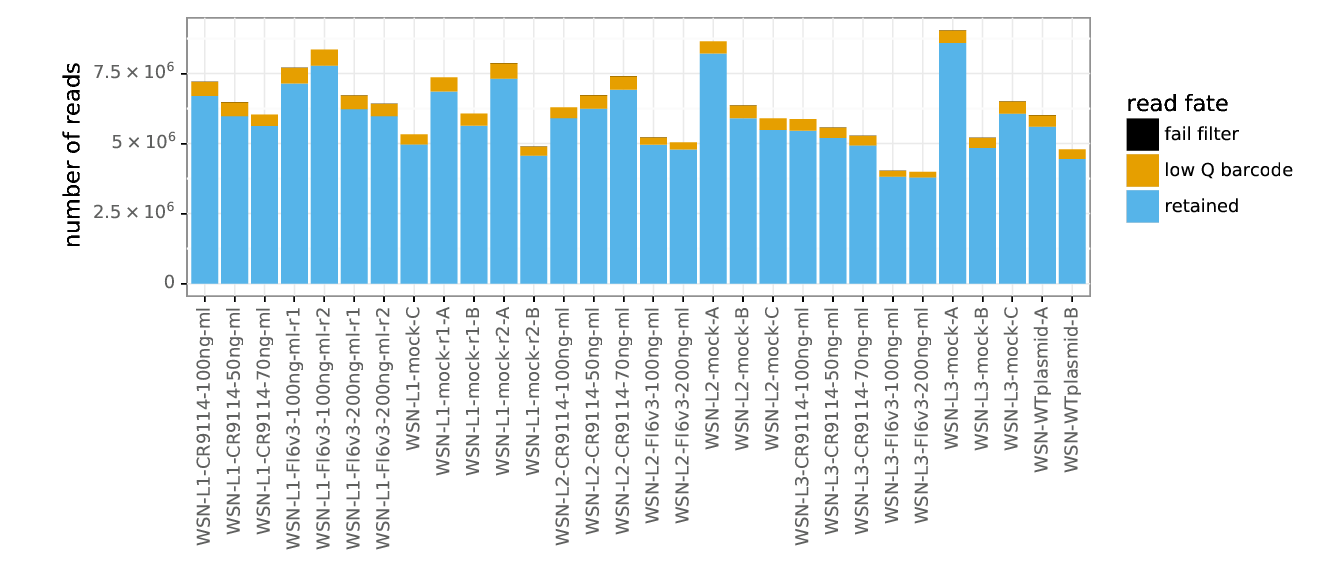

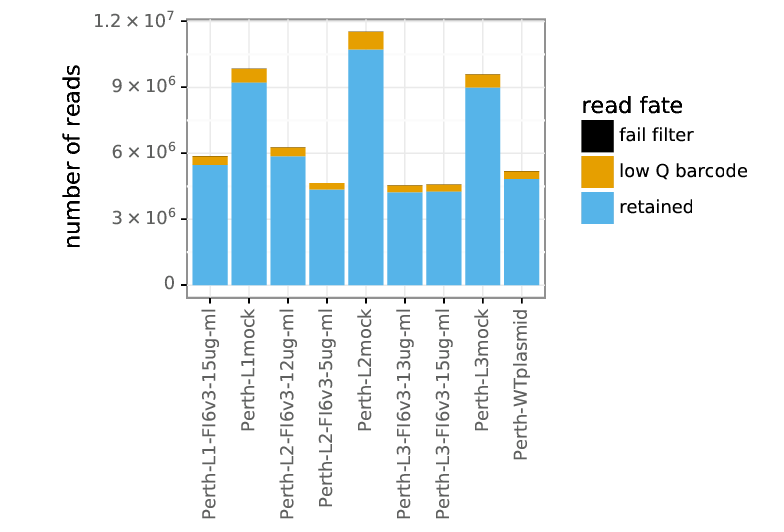

In [8]:
for prefix in [WSNcountsplotprefix, Perthcountsplotprefix]:
    showPDF(prefix + '_readstats.pdf')

This next plot shows the number of reads per barcode.
Overall read depth for all of the samples looks very good. 
The two WSN-L1mock-r*-A samples look a little undersequenced.

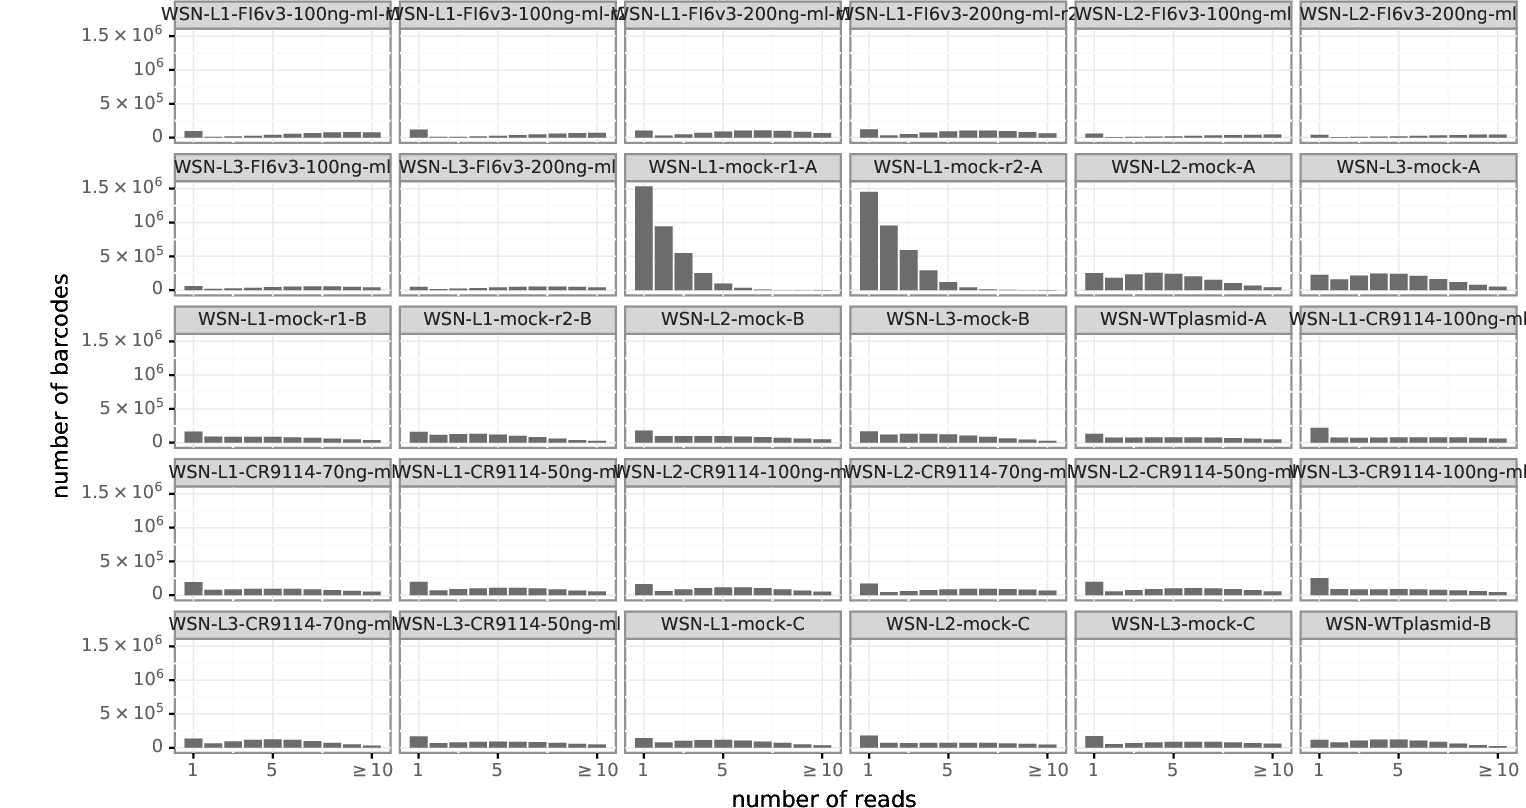

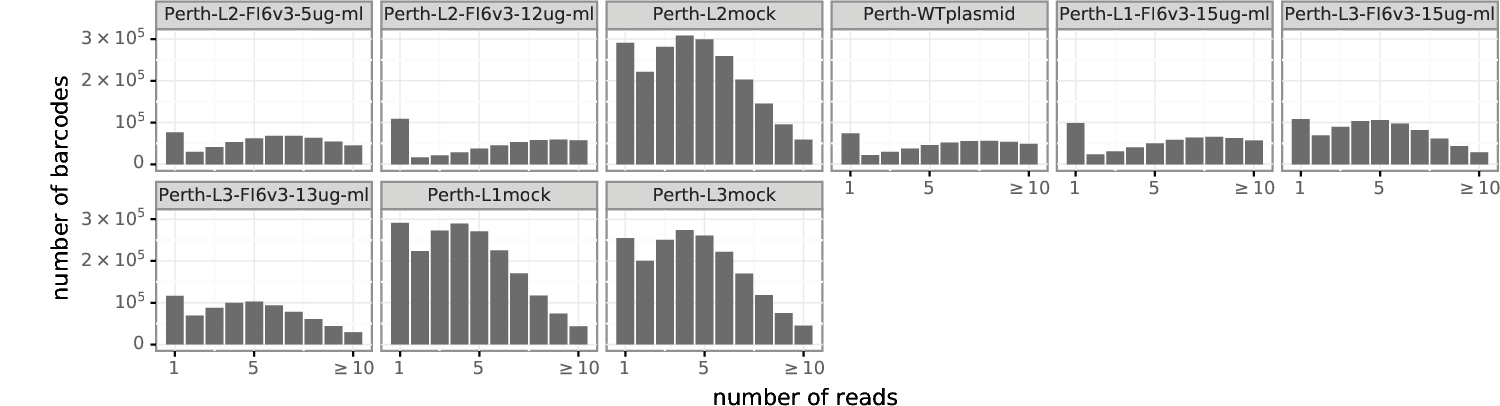

In [9]:
for prefix in [WSNcountsplotprefix, Perthcountsplotprefix]:
    showPDF(prefix + '_readsperbc.pdf')

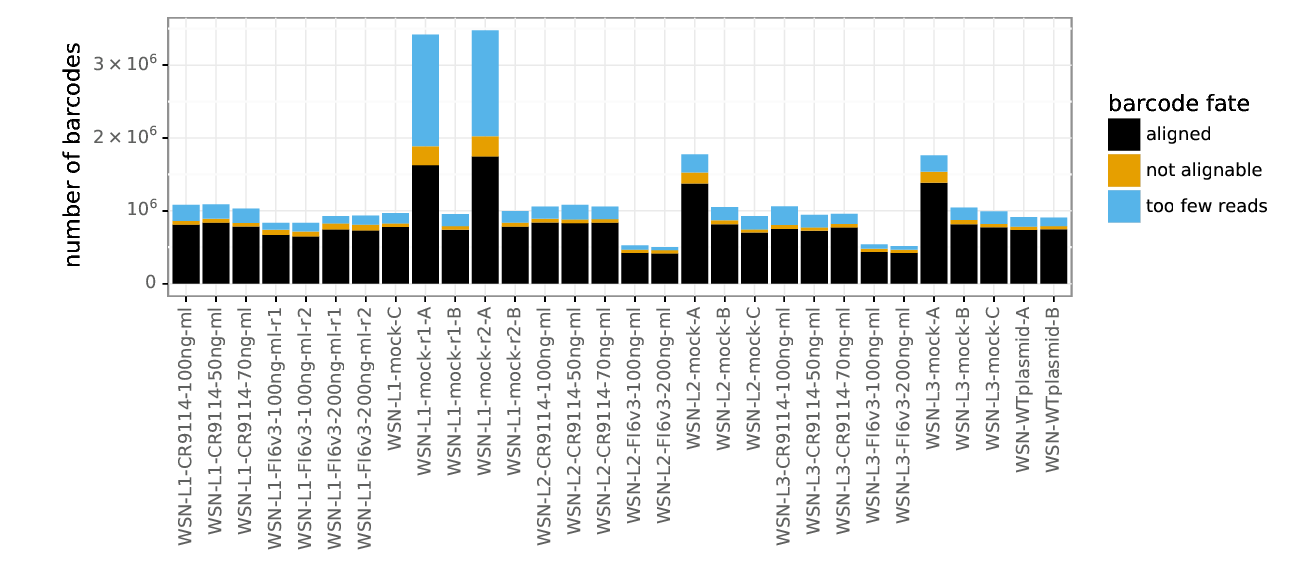

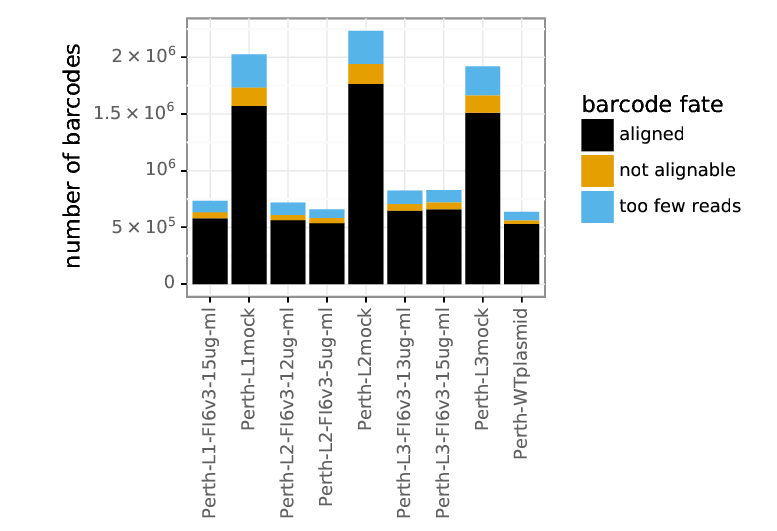

In [10]:
for prefix in [WSNcountsplotprefix, Perthcountsplotprefix]:
    showPDF(prefix + '_bcstats.pdf')

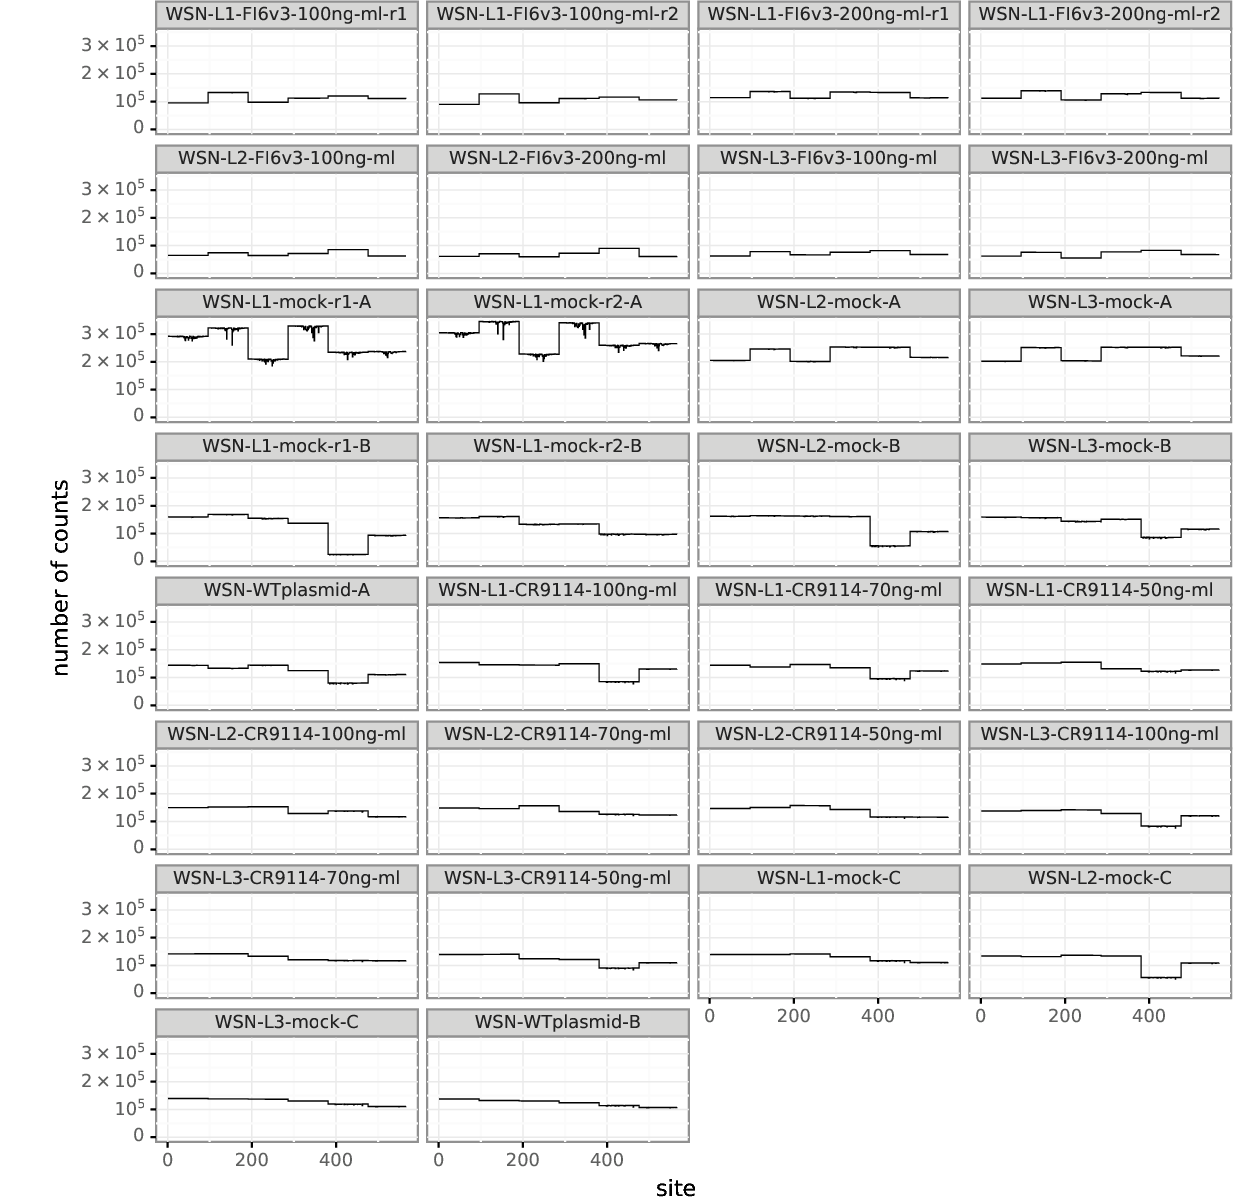

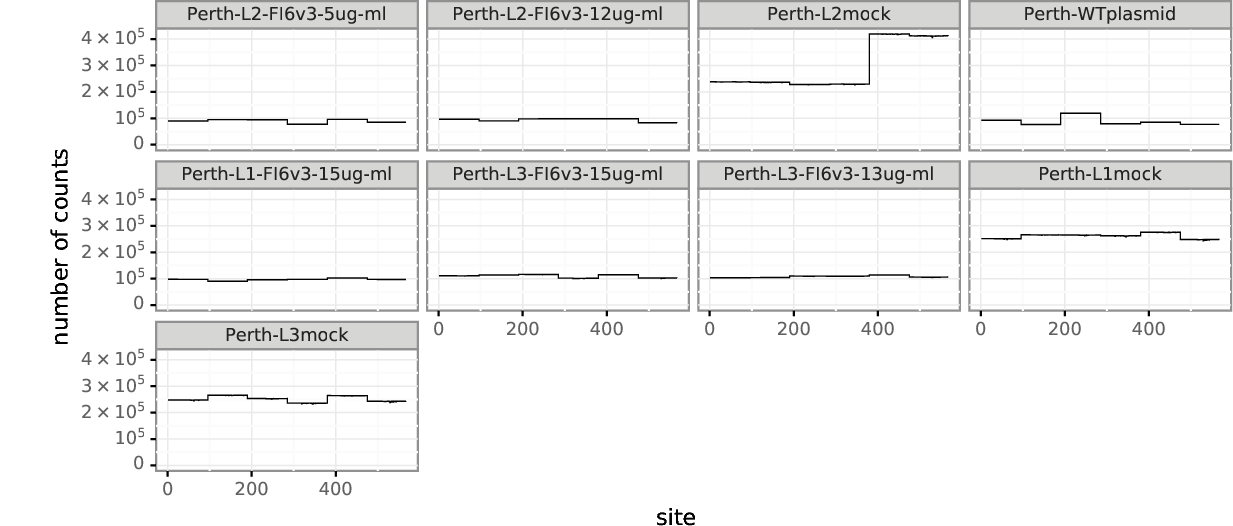

In [11]:
for prefix in [WSNcountsplotprefix, Perthcountsplotprefix]:
    showPDF(prefix + '_depth.pdf')

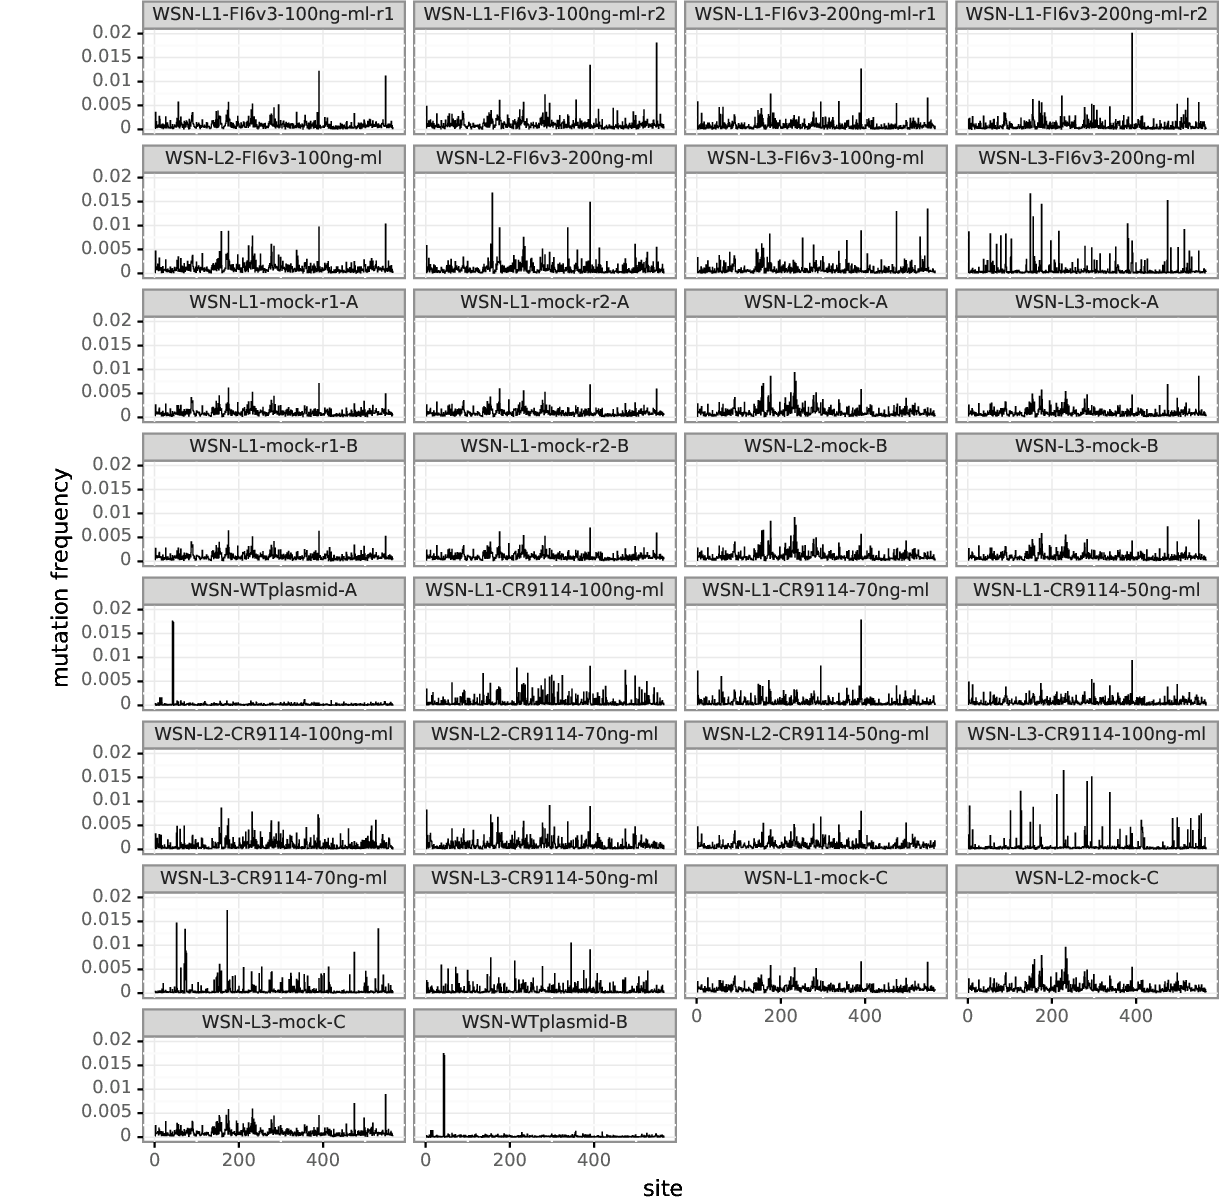

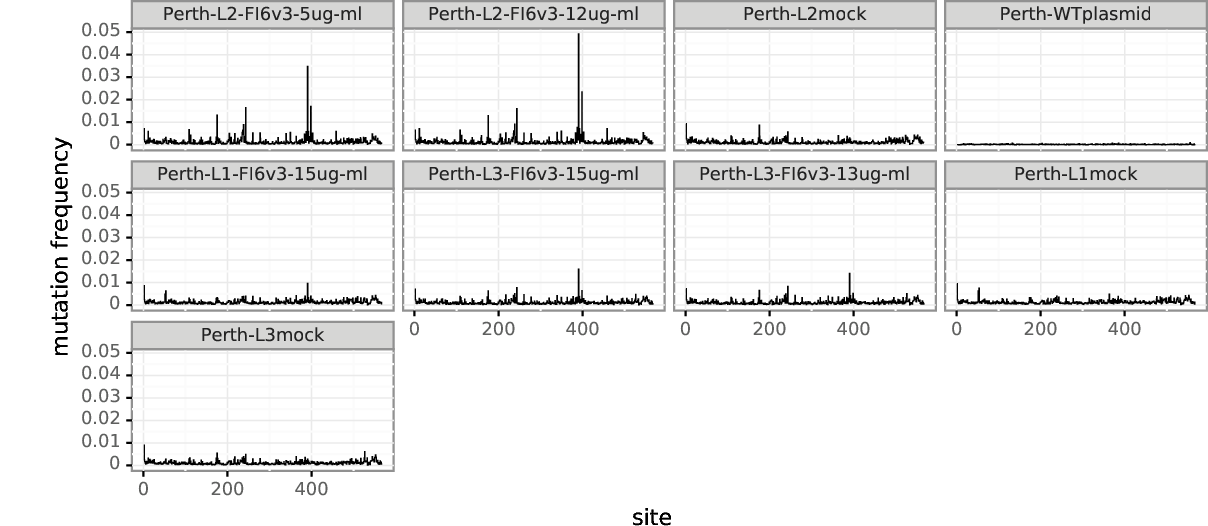

In [12]:
for prefix in [WSNcountsplotprefix, Perthcountsplotprefix]:
    showPDF(prefix + '_mutfreq.pdf')

The following plots display the mutation frequencies of nonsynonymous, stop, and synonymous codons. The majority of mutations are nonsynonymous.

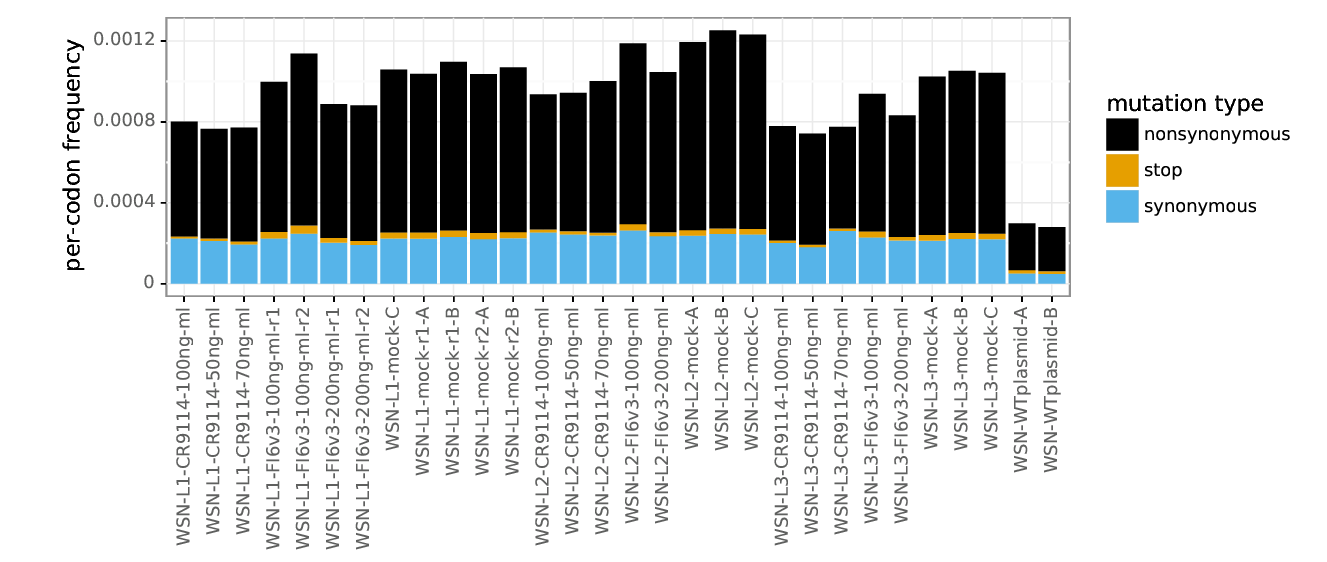

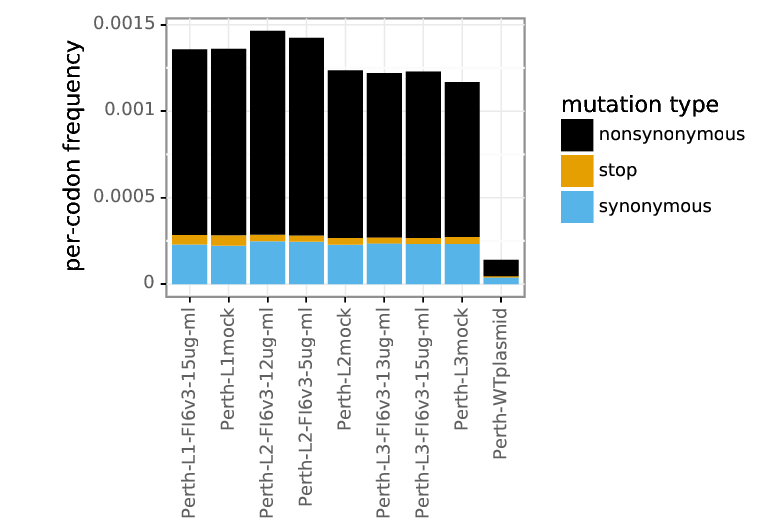

In [13]:
for prefix in [WSNcountsplotprefix, Perthcountsplotprefix]:
    showPDF(prefix + '_codonmuttypes.pdf')

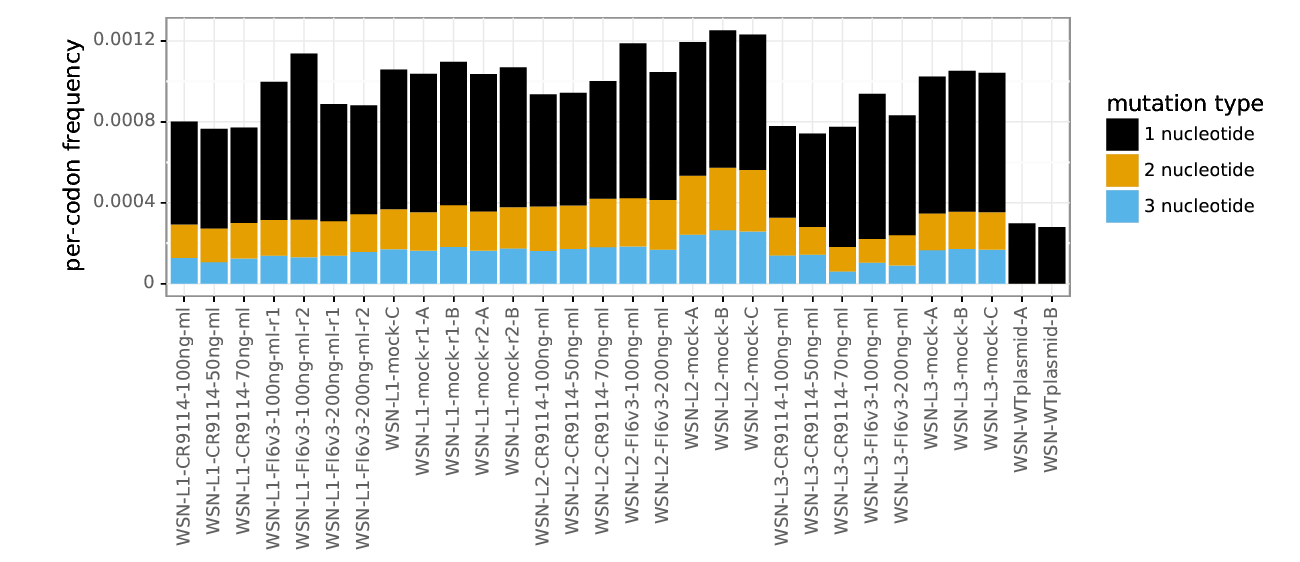

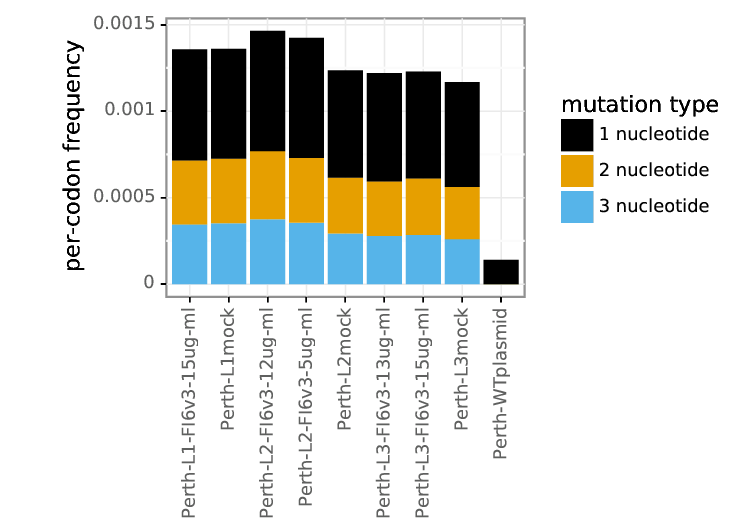

In [14]:
for prefix in [WSNcountsplotprefix, Perthcountsplotprefix]:
    showPDF(prefix + '_codonntchanges.pdf')

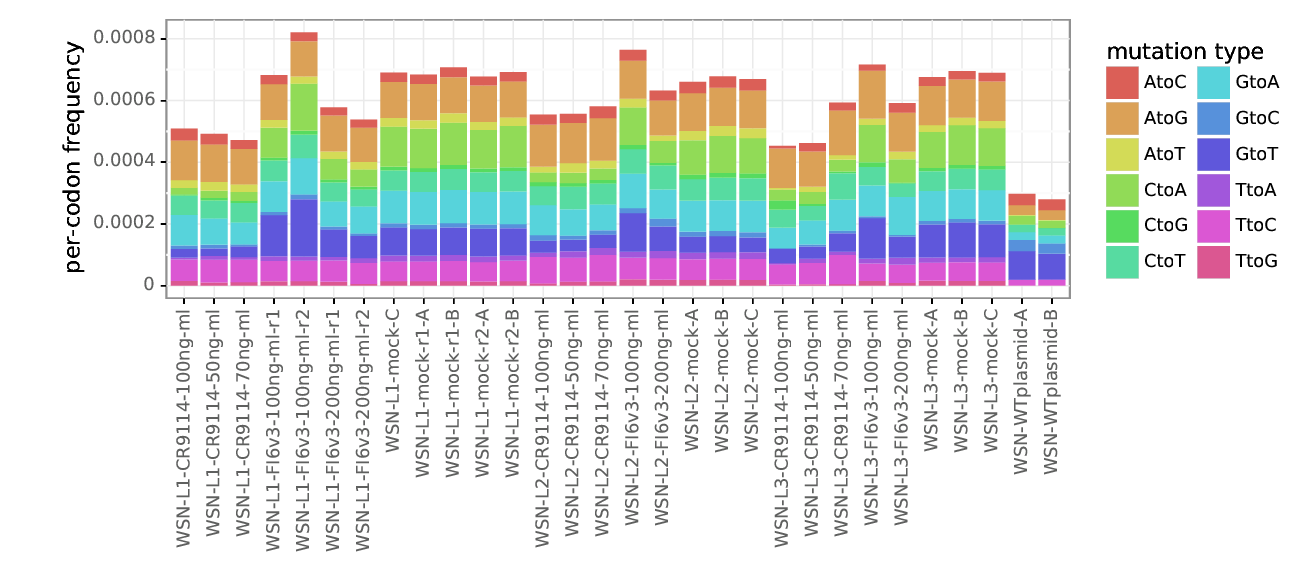

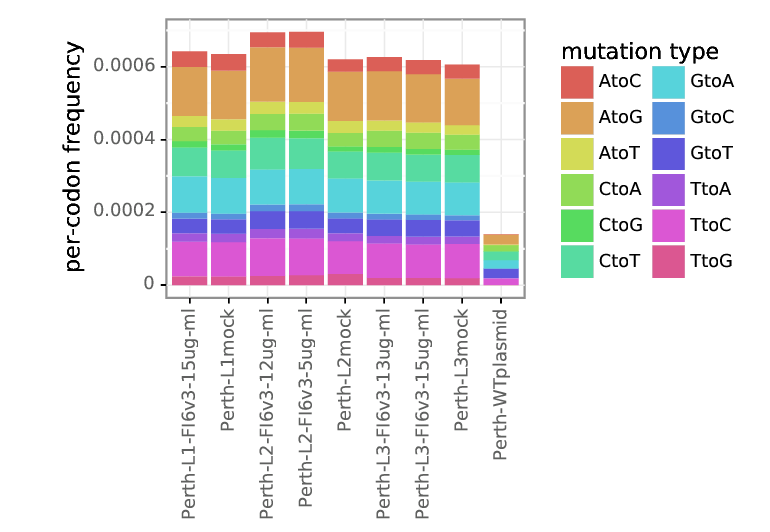

In [15]:
for prefix in [WSNcountsplotprefix, Perthcountsplotprefix]:
    showPDF(prefix + '_singlentchanges.pdf')

Some of the FI6v3-selected samples show signs of oxidative damage (enrichment of `G to T` and `C to A` mutations). This is also true for the WSN mock-selected samples and the WT plasmid, which were prepped from previous experiments and RNA extraction. In contrast, the remaining samples do not show much signs of oxidative damage. 

## Renumber codon counts to H3 numbering

We will now **renumber the codon counts** from sequential (1, 2, ... starting from the initial Met) to H3 numbering. The signal peptide is numbered with negative values, and the HA1 and HA2 subunits are numbered separately. This numbering scheme is based on an alignment to a PDB structure for an H3 HA 4HMG. We will use:

* The [./data/H1toH3_renumber.csv](./data/H1toH3_renumber.csv) file to convert the sequential numbers for the WSN H1 HA into the H3 numbering scheme
* The [./data/H3renumbering_scheme.csv](./data/H3renumbering_scheme.csv) file to convert the sequential numbers for the Perth/2009 H3 HA into the H3 numbering scheme
* The [dms_tools2.utils.renumberSites](https://jbloomlab.github.io/dms_tools2/dms_tools2.utils.html#dms_tools2.utils.renumberSites) function to renumber the codon counts files

The renumbered files will be created in a new `renumberedcounts` directory and will possess the same names as the original codon counts files created from dms2_batch_bcsubamp above.

In [16]:
# counts files to renumber
WSNcountsfiles = glob.glob('{0}/WSN*_codoncounts.csv'.format(countsdir))
Perthcountsfiles = glob.glob('{0}/Perth*_codoncounts.csv'.format(countsdir))

dms_tools2.utils.renumberSites('./data/H1toH3_renumber.csv', WSNcountsfiles, missing='drop', 
        outdir=renumberedcountsdir)
dms_tools2.utils.renumberSites('./data/H3renumbering_scheme.csv', Perthcountsfiles, missing='drop', 
        outdir=renumberedcountsdir)

## Profiling escape from different antibodies

Now we will use [dms2_batch_fracsurvive](https://jbloomlab.github.io/dms_tools2/fracsurvive.html) to profile escape from the different antibodies. This analysis estimates the fraction surviving antibody treatment for virions with each mutation.

We first define a `fracsurvivebatch` dataframe that we write to CSV format to use as input to [dms2_batch_fracsurvive](https://jbloomlab.github.io/dms_tools2/fracsurvive.html). Note how this dataframe contains a `libfracsurvive` column that gives the fraction of the library remaining infectious after antibody selection. This quantity was determined by qRT-PCR of RNA extracted from infected cells after library neutralization.

In [17]:
WSNfracsurvivebatch = pd.DataFrame.from_records([ 
        # WSN vs FI6v3 at 100 ng/ml
         ('WSN-FI6v3-100ng-ml', 'replicate-1a', 'WSN-L1-FI6v3-100ng-ml-r1', 'WSN-L1-mock-r1-A', 'WSN-WTplasmid-A'), 
         ('WSN-FI6v3-100ng-ml', 'replicate-1b', 'WSN-L1-FI6v3-100ng-ml-r2', 'WSN-L1-mock-r2-A', 'WSN-WTplasmid-A'),
         ('WSN-FI6v3-100ng-ml', 'replicate-2', 'WSN-L2-FI6v3-100ng-ml', 'WSN-L2-mock-A', 'WSN-WTplasmid-A'),
         ('WSN-FI6v3-100ng-ml', 'replicate-3', 'WSN-L3-FI6v3-100ng-ml', 'WSN-L3-mock-A', 'WSN-WTplasmid-A'),
        # WSN vs FI6v3 at 200 ng/ml
         ('WSN-FI6v3-200ng-ml', 'replicate-1a', 'WSN-L1-FI6v3-200ng-ml-r1', 'WSN-L1-mock-r1-A', 'WSN-WTplasmid-A'), 
         ('WSN-FI6v3-200ng-ml', 'replicate-1b', 'WSN-L1-FI6v3-200ng-ml-r2', 'WSN-L1-mock-r2-A', 'WSN-WTplasmid-A'),
         ('WSN-FI6v3-200ng-ml', 'replicate-2', 'WSN-L2-FI6v3-200ng-ml', 'WSN-L2-mock-A', 'WSN-WTplasmid-A'),
         ('WSN-FI6v3-200ng-ml', 'replicate-3', 'WSN-L3-FI6v3-200ng-ml', 'WSN-L3-mock-A', 'WSN-WTplasmid-A'),
        # WSN vs CR9114 at 100 ng/ml
         ('WSN-CR9114-100ng-ml', 'replicate-1', 'WSN-L1-CR9114-100ng-ml', 'WSN-L1-mock-C', 'WSN-WTplasmid-B'), 
         ('WSN-CR9114-100ng-ml', 'replicate-2', 'WSN-L2-CR9114-100ng-ml', 'WSN-L2-mock-C', 'WSN-WTplasmid-B'),
         ('WSN-CR9114-100ng-ml', 'replicate-3', 'WSN-L3-CR9114-100ng-ml', 'WSN-L3-mock-C', 'WSN-WTplasmid-B'),  
        # WSN vs CR9114 at 70 ng/ml
         ('WSN-CR9114-70ng-ml', 'replicate-1', 'WSN-L1-CR9114-70ng-ml', 'WSN-L1-mock-C', 'WSN-WTplasmid-B'),
         ('WSN-CR9114-70ng-ml', 'replicate-2', 'WSN-L2-CR9114-70ng-ml', 'WSN-L2-mock-C', 'WSN-WTplasmid-B'),
         ('WSN-CR9114-70ng-ml', 'replicate-3', 'WSN-L3-CR9114-70ng-ml', 'WSN-L3-mock-C', 'WSN-WTplasmid-B'), 
        # WSN vs CR9114 at 50 ng/ml
         ('WSN-CR9114-50ng-ml', 'replicate-1', 'WSN-L1-CR9114-50ng-ml', 'WSN-L1-mock-C', 'WSN-WTplasmid-B'), 
         ('WSN-CR9114-50ng-ml', 'replicate-2', 'WSN-L2-CR9114-50ng-ml', 'WSN-L2-mock-C', 'WSN-WTplasmid-B'), 
         ('WSN-CR9114-50ng-ml', 'replicate-3', 'WSN-L3-CR9114-50ng-ml', 'WSN-L3-mock-C', 'WSN-WTplasmid-B')
        ],       
        columns=['group', 'name', 'sel', 'mock', 'err']
        )

# add the libfracsurvive values from the previously defined `samples` dataframe
WSNfracsurvivebatch = pd.merge(WSNfracsurvivebatch, samples[['name', 'libfracsurvive']], 
        left_on = 'sel', right_on= 'name', suffixes=('', '_y')).drop('name_y', axis=1)

# make nicely formatted grouplabels (antibody names) for faceted plots
WSNfracsurvivebatch['grouplabel'] = (WSNfracsurvivebatch['group']
        .str.replace('-ml', '/ml)')
        .str.replace('WSN-', 'WSN vs ')
        .str.replace('-', ' (')
        .str.replace('ng', ' ng')
        .str.replace('ug', ' $\mu$g')
        )

# add column with antibody name, which is word item in group name
WSNfracsurvivebatch['antibody'] = list(map(lambda g: g.split('-')[1], WSNfracsurvivebatch['group']))

# display and write information
WSNfracsurvivebatchfile = os.path.join(fracsurvivedir, 'WSNbatch.csv')
print("Here is the batch input that we write to the CSV file {0}:".format(WSNfracsurvivebatchfile))
display(HTML(WSNfracsurvivebatch.to_html(index=False)))
WSNfracsurvivebatch.to_csv(WSNfracsurvivebatchfile, index=False)

Here is the batch input that we write to the CSV file ./results/fracsurvive/WSNbatch.csv:


group,name,sel,mock,err,libfracsurvive,grouplabel,antibody
WSN-FI6v3-100ng-ml,replicate-1a,WSN-L1-FI6v3-100ng-ml-r1,WSN-L1-mock-r1-A,WSN-WTplasmid-A,0.01662,WSN vs FI6v3 (100 ng/ml),FI6v3
WSN-FI6v3-100ng-ml,replicate-1b,WSN-L1-FI6v3-100ng-ml-r2,WSN-L1-mock-r2-A,WSN-WTplasmid-A,0.01390,WSN vs FI6v3 (100 ng/ml),FI6v3
WSN-FI6v3-100ng-ml,replicate-2,WSN-L2-FI6v3-100ng-ml,WSN-L2-mock-A,WSN-WTplasmid-A,0.02322,WSN vs FI6v3 (100 ng/ml),FI6v3
WSN-FI6v3-100ng-ml,replicate-3,WSN-L3-FI6v3-100ng-ml,WSN-L3-mock-A,WSN-WTplasmid-A,0.00903,WSN vs FI6v3 (100 ng/ml),FI6v3
WSN-FI6v3-200ng-ml,replicate-1a,WSN-L1-FI6v3-200ng-ml-r1,WSN-L1-mock-r1-A,WSN-WTplasmid-A,0.00465,WSN vs FI6v3 (200 ng/ml),FI6v3
WSN-FI6v3-200ng-ml,replicate-1b,WSN-L1-FI6v3-200ng-ml-r2,WSN-L1-mock-r2-A,WSN-WTplasmid-A,0.00345,WSN vs FI6v3 (200 ng/ml),FI6v3
WSN-FI6v3-200ng-ml,replicate-2,WSN-L2-FI6v3-200ng-ml,WSN-L2-mock-A,WSN-WTplasmid-A,0.00278,WSN vs FI6v3 (200 ng/ml),FI6v3
WSN-FI6v3-200ng-ml,replicate-3,WSN-L3-FI6v3-200ng-ml,WSN-L3-mock-A,WSN-WTplasmid-A,0.00144,WSN vs FI6v3 (200 ng/ml),FI6v3
WSN-CR9114-100ng-ml,replicate-1,WSN-L1-CR9114-100ng-ml,WSN-L1-mock-C,WSN-WTplasmid-B,0.00204,WSN vs CR9114 (100 ng/ml),CR9114
WSN-CR9114-100ng-ml,replicate-2,WSN-L2-CR9114-100ng-ml,WSN-L2-mock-C,WSN-WTplasmid-B,0.00186,WSN vs CR9114 (100 ng/ml),CR9114


In [18]:
Perthfracsurvivebatch = pd.DataFrame.from_records([ 
        # Perth vs FI6v3 at 5 ug/ml
         ('Perth-FI6v3-5ug-ml', 'replicate-2', 'Perth-L2-FI6v3-5ug-ml', 'Perth-L2mock', 'Perth-WTplasmid'), 
        # Perth vs FI6v3 at 12 to 15 ug/ml
         ('Perth-FI6v3', 'replicate-1', 'Perth-L1-FI6v3-15ug-ml', 'Perth-L1mock', 'Perth-WTplasmid'), 
         ('Perth-FI6v3', 'replicate-2', 'Perth-L2-FI6v3-12ug-ml', 'Perth-L2mock', 'Perth-WTplasmid'),
         ('Perth-FI6v3', 'replicate-3a', 'Perth-L3-FI6v3-13ug-ml', 'Perth-L3mock', 'Perth-WTplasmid'),
         ('Perth-FI6v3', 'replicate-3b', 'Perth-L3-FI6v3-15ug-ml', 'Perth-L3mock', 'Perth-WTplasmid')
        ],       
        columns=['group', 'name', 'sel', 'mock', 'err']
        )

# add the libfracsurvive values from the previously defined `samples` dataframe
Perthfracsurvivebatch = pd.merge(Perthfracsurvivebatch, samples[['name', 'libfracsurvive']], 
        left_on = 'sel', right_on= 'name', suffixes=('', '_y')).drop('name_y', axis=1)

# make nicely formatted grouplabels (antibody names) for faceted plots
Perthfracsurvivebatch['grouplabel'] = (Perthfracsurvivebatch['group']
        .str.replace('-ml', '/ml)')
        .str.replace('Perth-', 'Perth vs ')
        .str.replace('-', ' (')
        .str.replace('ng', ' ng')
        .str.replace('ug', ' $\mu$g')
        )

# add column with antibody name, which is word item in group name
Perthfracsurvivebatch['antibody'] = list(map(lambda g: g.split('-')[1], Perthfracsurvivebatch['group']))

# display and write information
Perthfracsurvivebatchfile = os.path.join(fracsurvivedir, 'batch.csv')
print("Here is the batch input that we write to the CSV file {0}:".format(Perthfracsurvivebatchfile))
display(HTML(Perthfracsurvivebatch.to_html(index=False)))
Perthfracsurvivebatch.to_csv(Perthfracsurvivebatchfile, index=False)

Here is the batch input that we write to the CSV file ./results/fracsurvive/batch.csv:


group,name,sel,mock,err,libfracsurvive,grouplabel,antibody
Perth-FI6v3-5ug-ml,replicate-2,Perth-L2-FI6v3-5ug-ml,Perth-L2mock,Perth-WTplasmid,0.07399,Perth vs FI6v3 (5 $\mu$g/ml),FI6v3
Perth-FI6v3,replicate-1,Perth-L1-FI6v3-15ug-ml,Perth-L1mock,Perth-WTplasmid,0.06218,Perth vs FI6v3,FI6v3
Perth-FI6v3,replicate-2,Perth-L2-FI6v3-12ug-ml,Perth-L2mock,Perth-WTplasmid,0.04329,Perth vs FI6v3,FI6v3
Perth-FI6v3,replicate-3a,Perth-L3-FI6v3-13ug-ml,Perth-L3mock,Perth-WTplasmid,0.06180,Perth vs FI6v3,FI6v3
Perth-FI6v3,replicate-3b,Perth-L3-FI6v3-15ug-ml,Perth-L3mock,Perth-WTplasmid,0.06864,Perth vs FI6v3,FI6v3


We now run `dms2_batch_fracsurvive` twice with the following difference:

* First we run it simply computing the fraction surviving for each mutation.
* Then we run it with the `--aboveavg yes` option to compute the fraction surviving for each mutation **above the overall library average.**

Note how the results for these two different runs are output to **two different subdirectories.**

In [19]:
for (arg_aboveavg, outdir) in [('', fracsurvivedir), 
                               ('--aboveavg yes', fracsurviveaboveavgdir)]:
    print("\nRunning dms2_batch_fracsurvive {0}and writing output to {1}".format(
            {'':'', '--aboveavg yes':'with `--aboveavg yes` '}[arg_aboveavg], outdir))
    log = !dms2_batch_fracsurvive \
            --summaryprefix WSNsummary \
            --batchfile {WSNfracsurvivebatchfile} \
            --outdir {outdir} \
            --indir {renumberedcountsdir} \
            --use_existing {use_existing} \
            {arg_aboveavg} 
    print("Completed run.")


Running dms2_batch_fracsurvive and writing output to ./results/fracsurvive/
Completed run.

Running dms2_batch_fracsurvive with `--aboveavg yes` and writing output to ./results/fracsurviveaboveavg/
Completed run.


In [20]:
for (arg_aboveavg, outdir) in [('', fracsurvivedir), 
                               ('--aboveavg yes', fracsurviveaboveavgdir)]:
    print("\nRunning dms2_batch_fracsurvive {0}and writing output to {1}".format(
            {'':'', '--aboveavg yes':'with `--aboveavg yes` '}[arg_aboveavg], outdir))
    log = !dms2_batch_fracsurvive \
            --summaryprefix Perthsummary \
            --batchfile {Perthfracsurvivebatchfile} \
            --outdir {outdir} \
            --indir {renumberedcountsdir} \
            --use_existing {use_existing} \
            {arg_aboveavg} 
    print("Completed run.")


Running dms2_batch_fracsurvive and writing output to ./results/fracsurvive/
Completed run.

Running dms2_batch_fracsurvive with `--aboveavg yes` and writing output to ./results/fracsurviveaboveavg/
Completed run.


For all plots below, we will show the results for the analysis where we compute the average fraction surviving **above average.** First, we define the prefix for the summary plots for the fraction surviving above average. Again, the WSN-selected libraries and the Perth/2009-selected libraries will have different prefixes:

In [21]:
WSNfracsurviveprefix = os.path.join(fracsurviveaboveavgdir, 'WSNsummary_')
Perthfracsurviveprefix = os.path.join(fracsurviveaboveavgdir, 'Perthsummary_')

First, we look to see the correlations among the replicates for each concentration. We do this looking at the **average fraction surviving** at each site, averaged over all mutations at that site. These plots have the suffix `avgfracsurvivecorr.pdf`. 

As seen below, the correlations are poor across the **WSN H1** replicates for all antibody concentrations of FI6v3 and CR9114. This corresponds to the earlier finding of [Doud, Lee, and Bloom (2018)](https://www.nature.com/articles/s41467-018-03665-3), where correlations between replicates for anti-stalk antibodies were generally very poor. This is because there are no strong escape mutants from these antibodies, so the noise in the experiments lead to smaller correlations among replicates.

However, we see that the correlations between the **Perth/2009 H3** replicates selected with FI6v3 are very high. These correlations are similar to what we saw when selecting with an antibody that was relatively easy to escape from, strongly suggesting that the Perth/2009 mutant library may have several escape mutations with large effect sizes on escape.


Replicate correlations for FI6v3


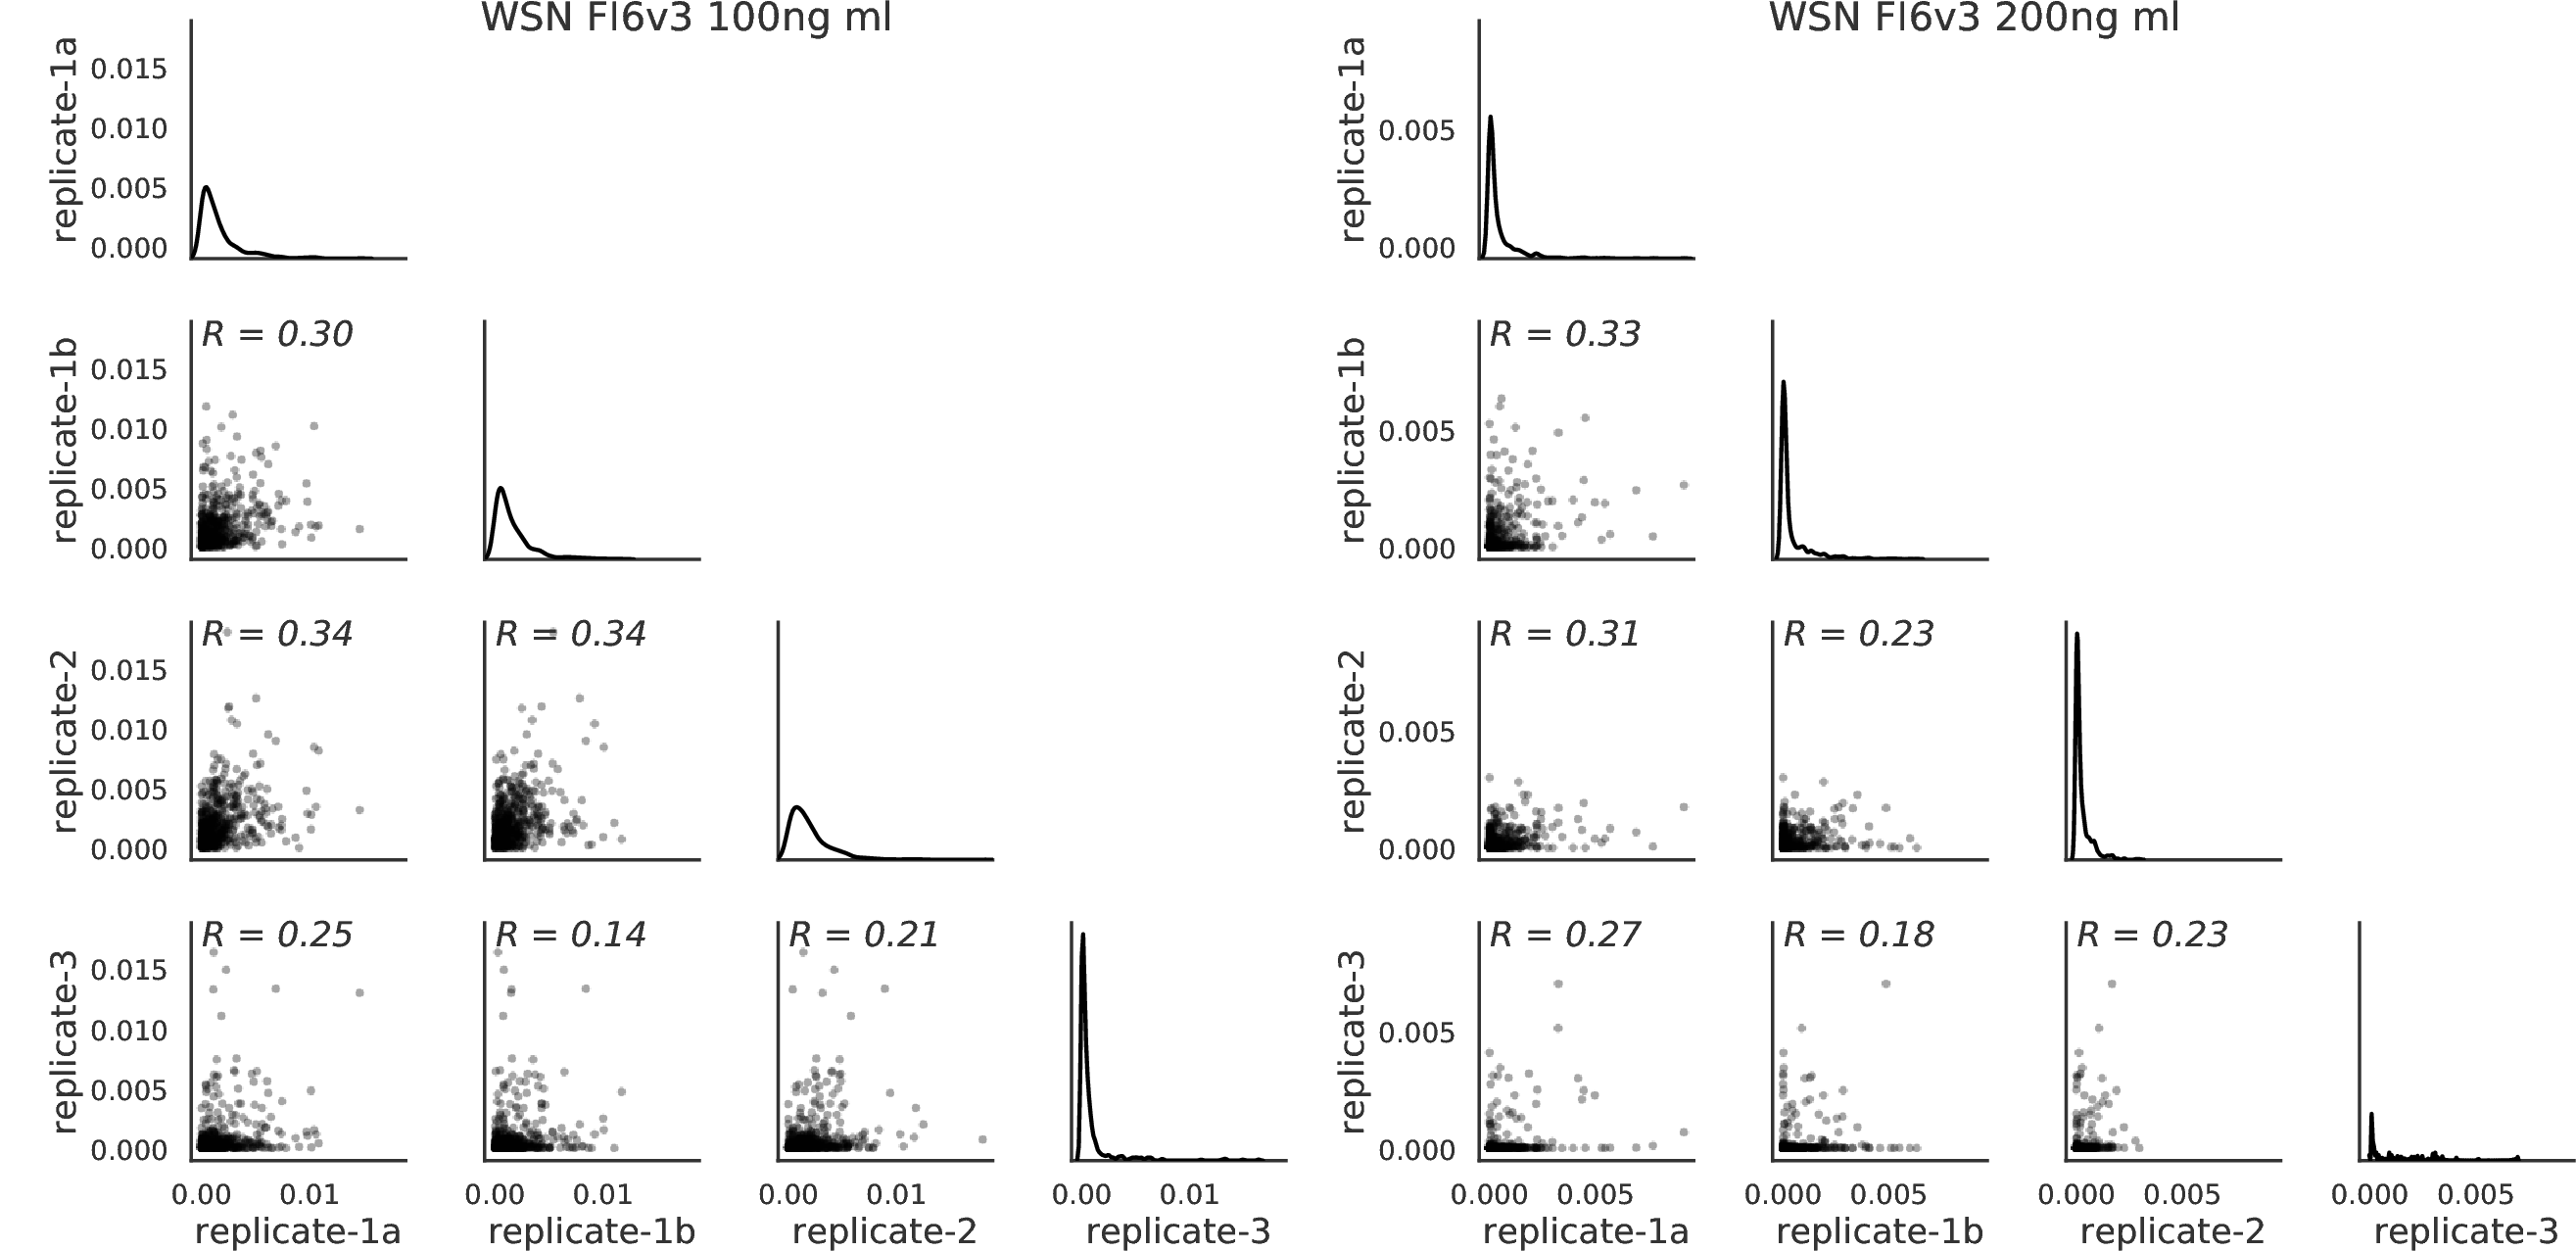


Replicate correlations for CR9114


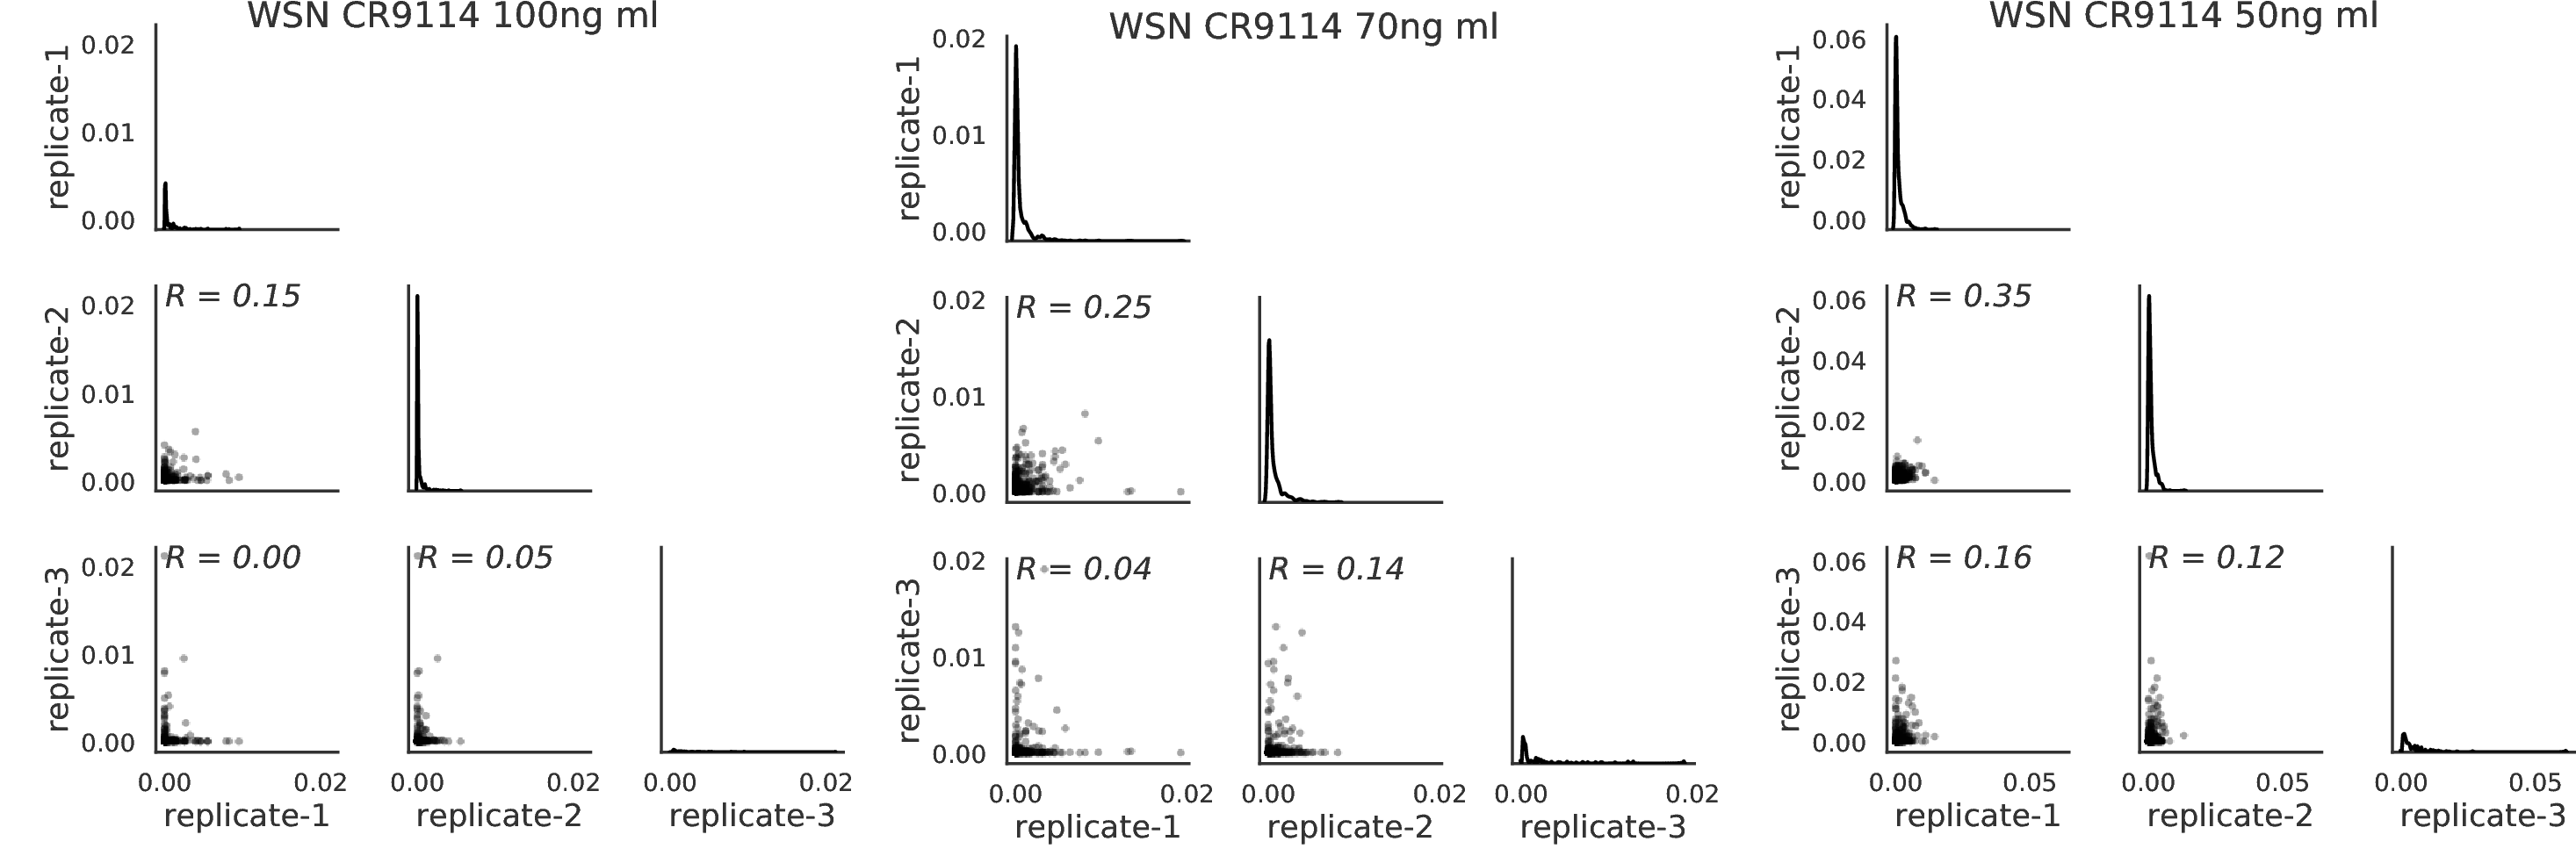

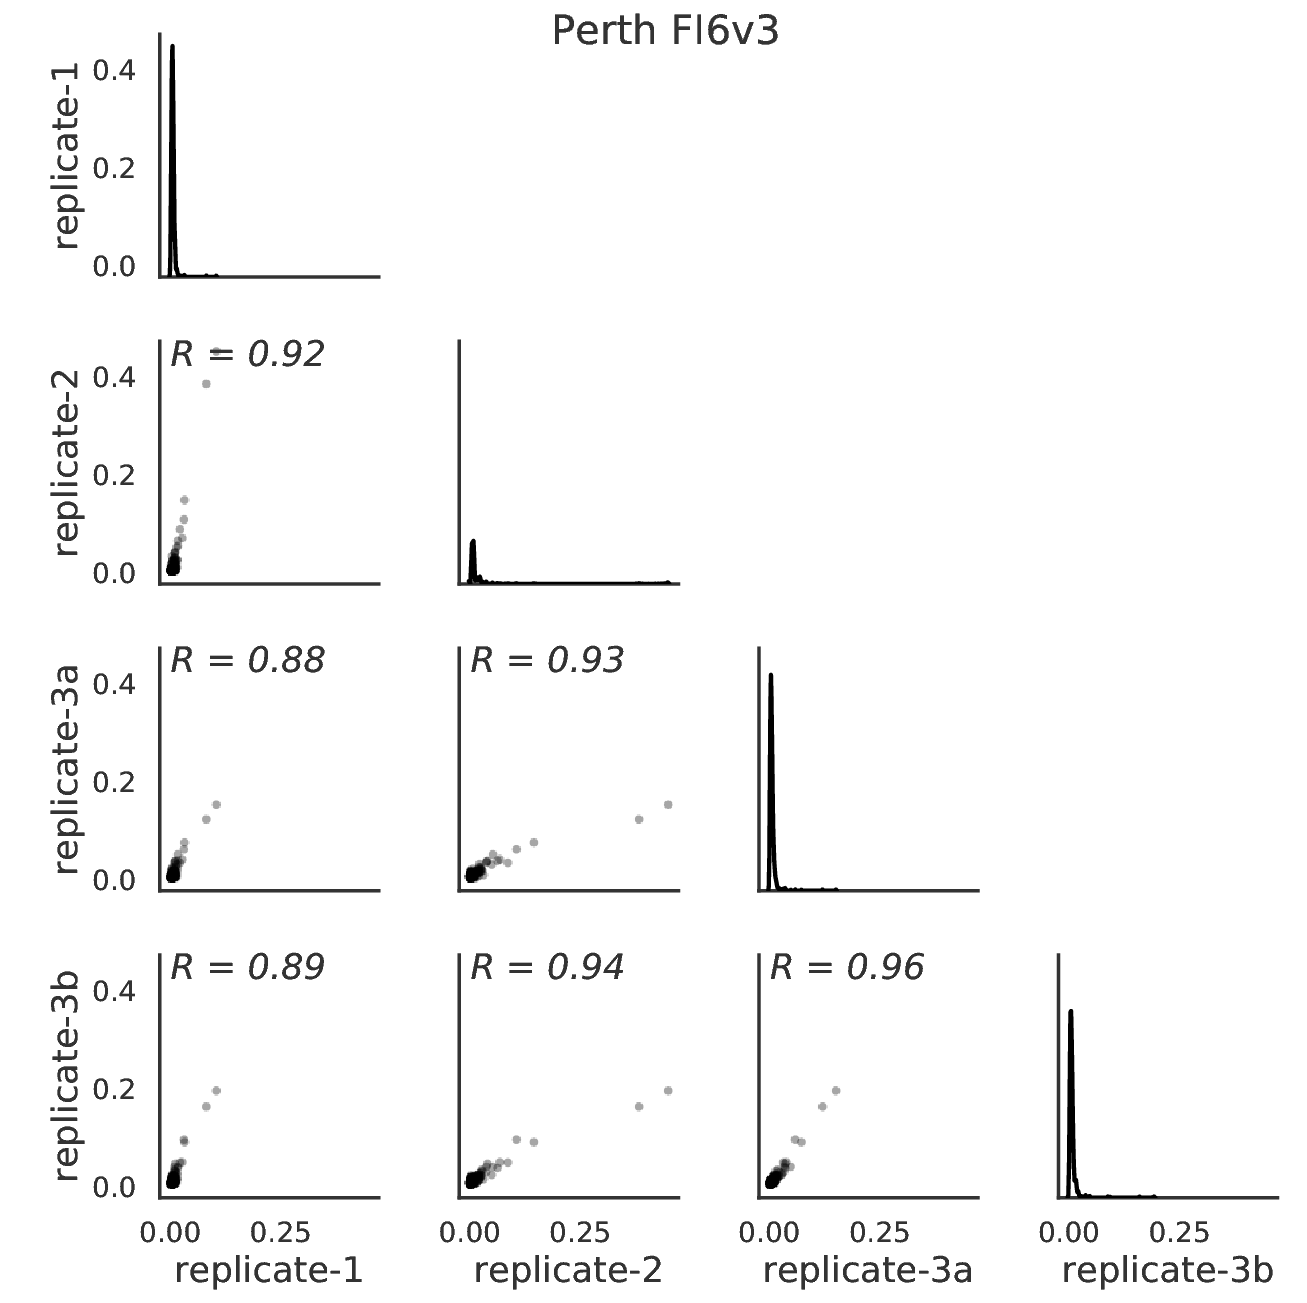

In [22]:
for antibody in WSNfracsurvivebatch['antibody'].unique():
    groups = WSNfracsurvivebatch.query('antibody == @antibody')['group'].unique()
    plots = [WSNfracsurviveprefix + g + '-avgfracsurvivecorr.pdf' for g in groups]
    print("\nReplicate correlations for {0}".format(antibody))
    showPDF(plots, width=300 * len(plots))
    
showPDF(Perthfracsurviveprefix + 'Perth-FI6v3-avgfracsurvivecorr.pdf', width=400)

Now we want to look across the HA sequence to see the fraction surviving above average for each antibody / concentration.

Here we use the *median* to summarize across antibodies and concentrations, as that looks slightly cleaner as it reduces the effects of outliers more.

First we look at the fraction escape averaged across all mutations at a site:

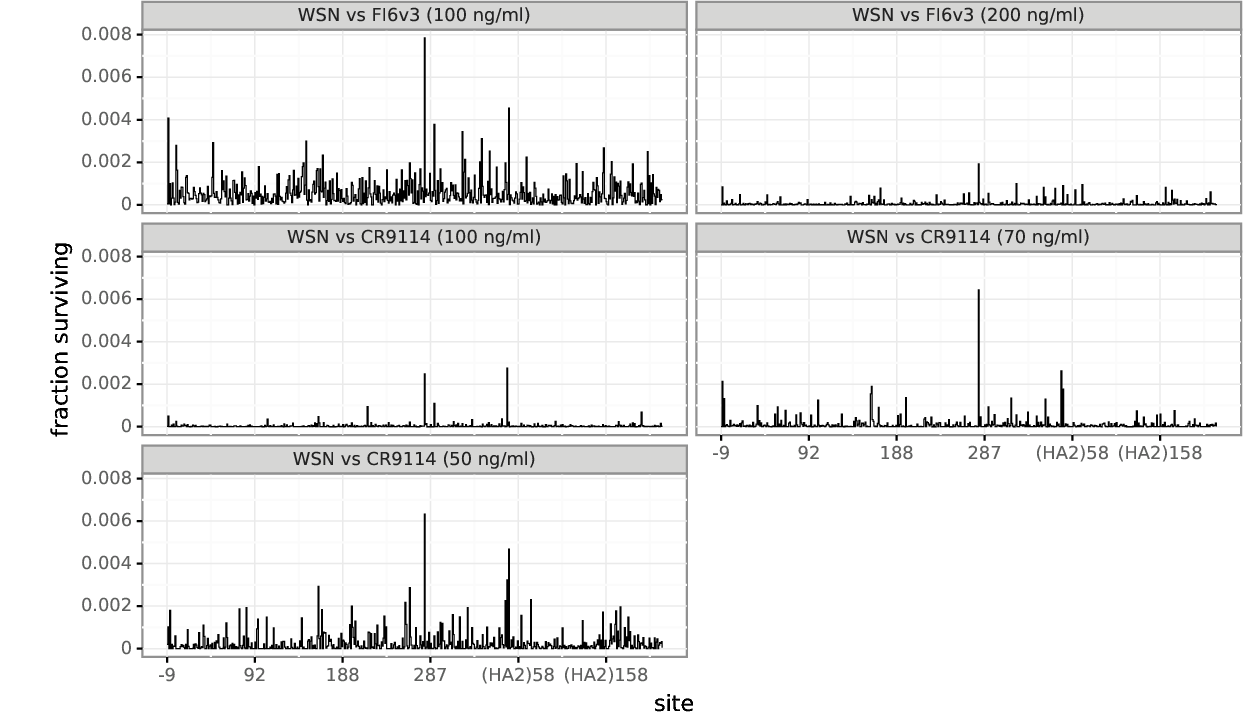

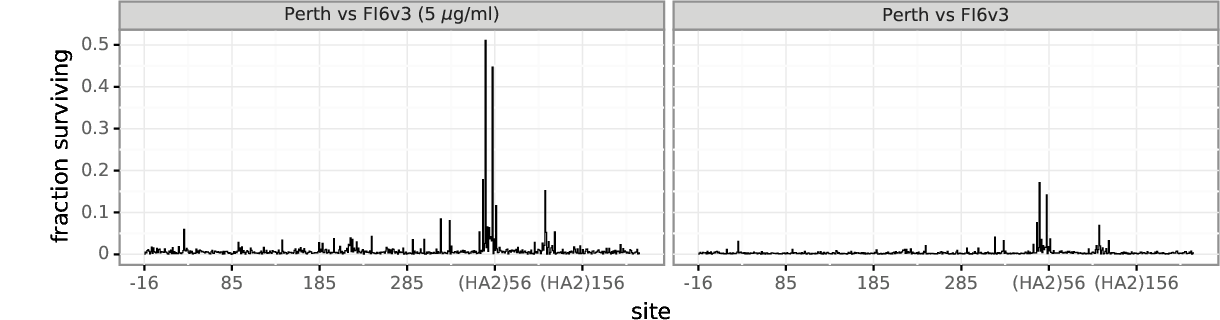

In [23]:
for prefix in [WSNfracsurviveprefix, Perthfracsurviveprefix]:
    showPDF(prefix + 'medianavgfracsurvive.pdf', width=800)

Now we look at the fraction escape for the amino-acid mutation with the maximum effect at each site:

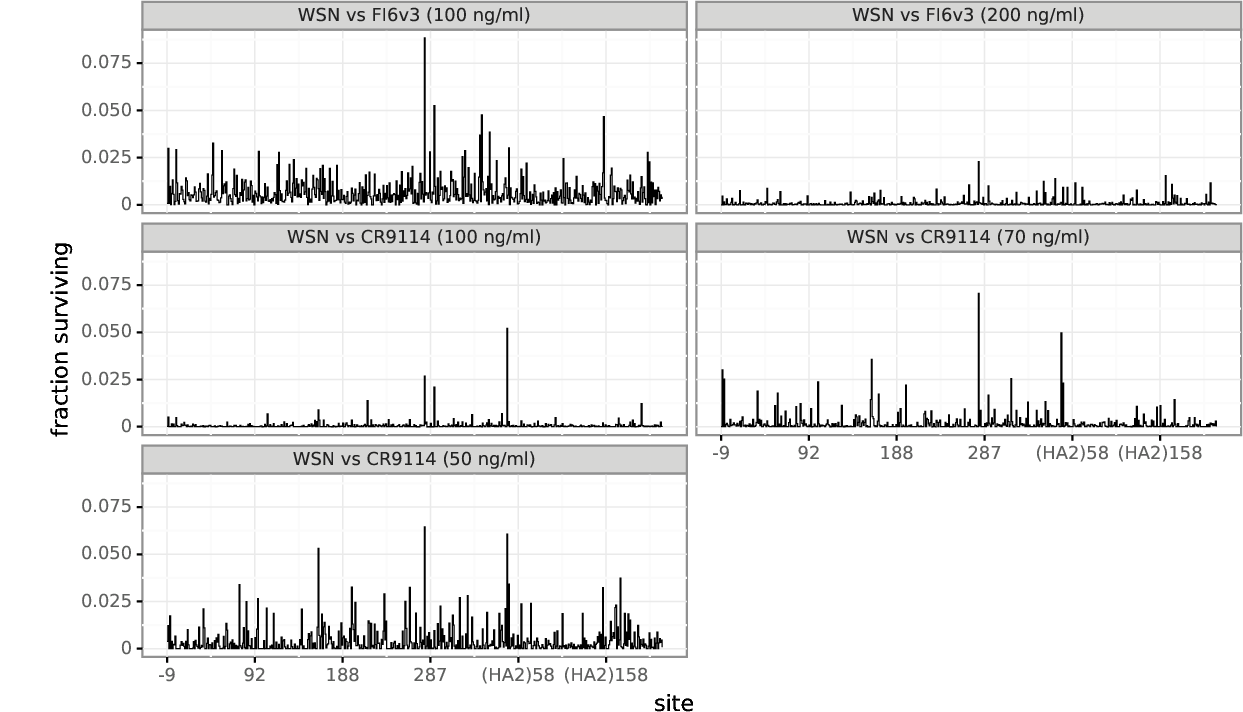

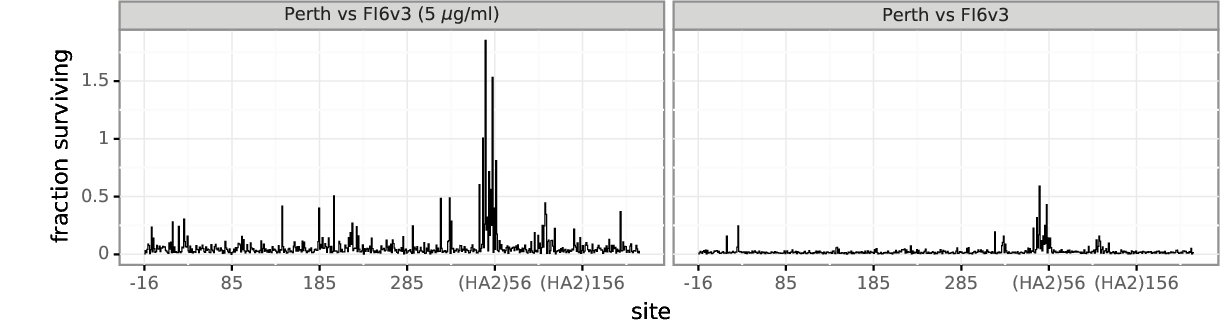

In [24]:
for prefix in [WSNfracsurviveprefix, Perthfracsurviveprefix]:
    showPDF(prefix + 'medianmaxfracsurvive.pdf', width=800)

From the plots above it is immediately apparent that FI6v3 selects for escape mutations with _large_ effect sizes in the Perth/2009 H3 HA as compared to escape mutations in the WSN H1 (note the difference in scale of the y-axes of the WSN and Perth/2009 plots). We also see large effect size mutations at a handful of sites in the Perth/2009 H3 selected by FI6v3, whereas we do not see a clear set of sites selected by FI6v3 or CR9114 against WSN H1.

Now for each antibody, we will take the median across antibody concentrations of the across-replicate medians, and use these to make logo plots for each antibody.


Getting and plotting overall across-concentration median for WSN vs FI6v3
Writing across-concentration medians to ./results/fracsurviveaboveavg/antibody_FI6v3_WSN_median.csv
Writing across-concentration site medians to ./results/fracsurviveaboveavg/antibody_FI6v3_WSN_median_avgsite.csv
Creating logo plot ./results/fracsurviveaboveavg/WSN-FI6v3_fracsurvive.pdf for FI6v3 from ./results/fracsurviveaboveavg/antibody_FI6v3_WSN_median.csv


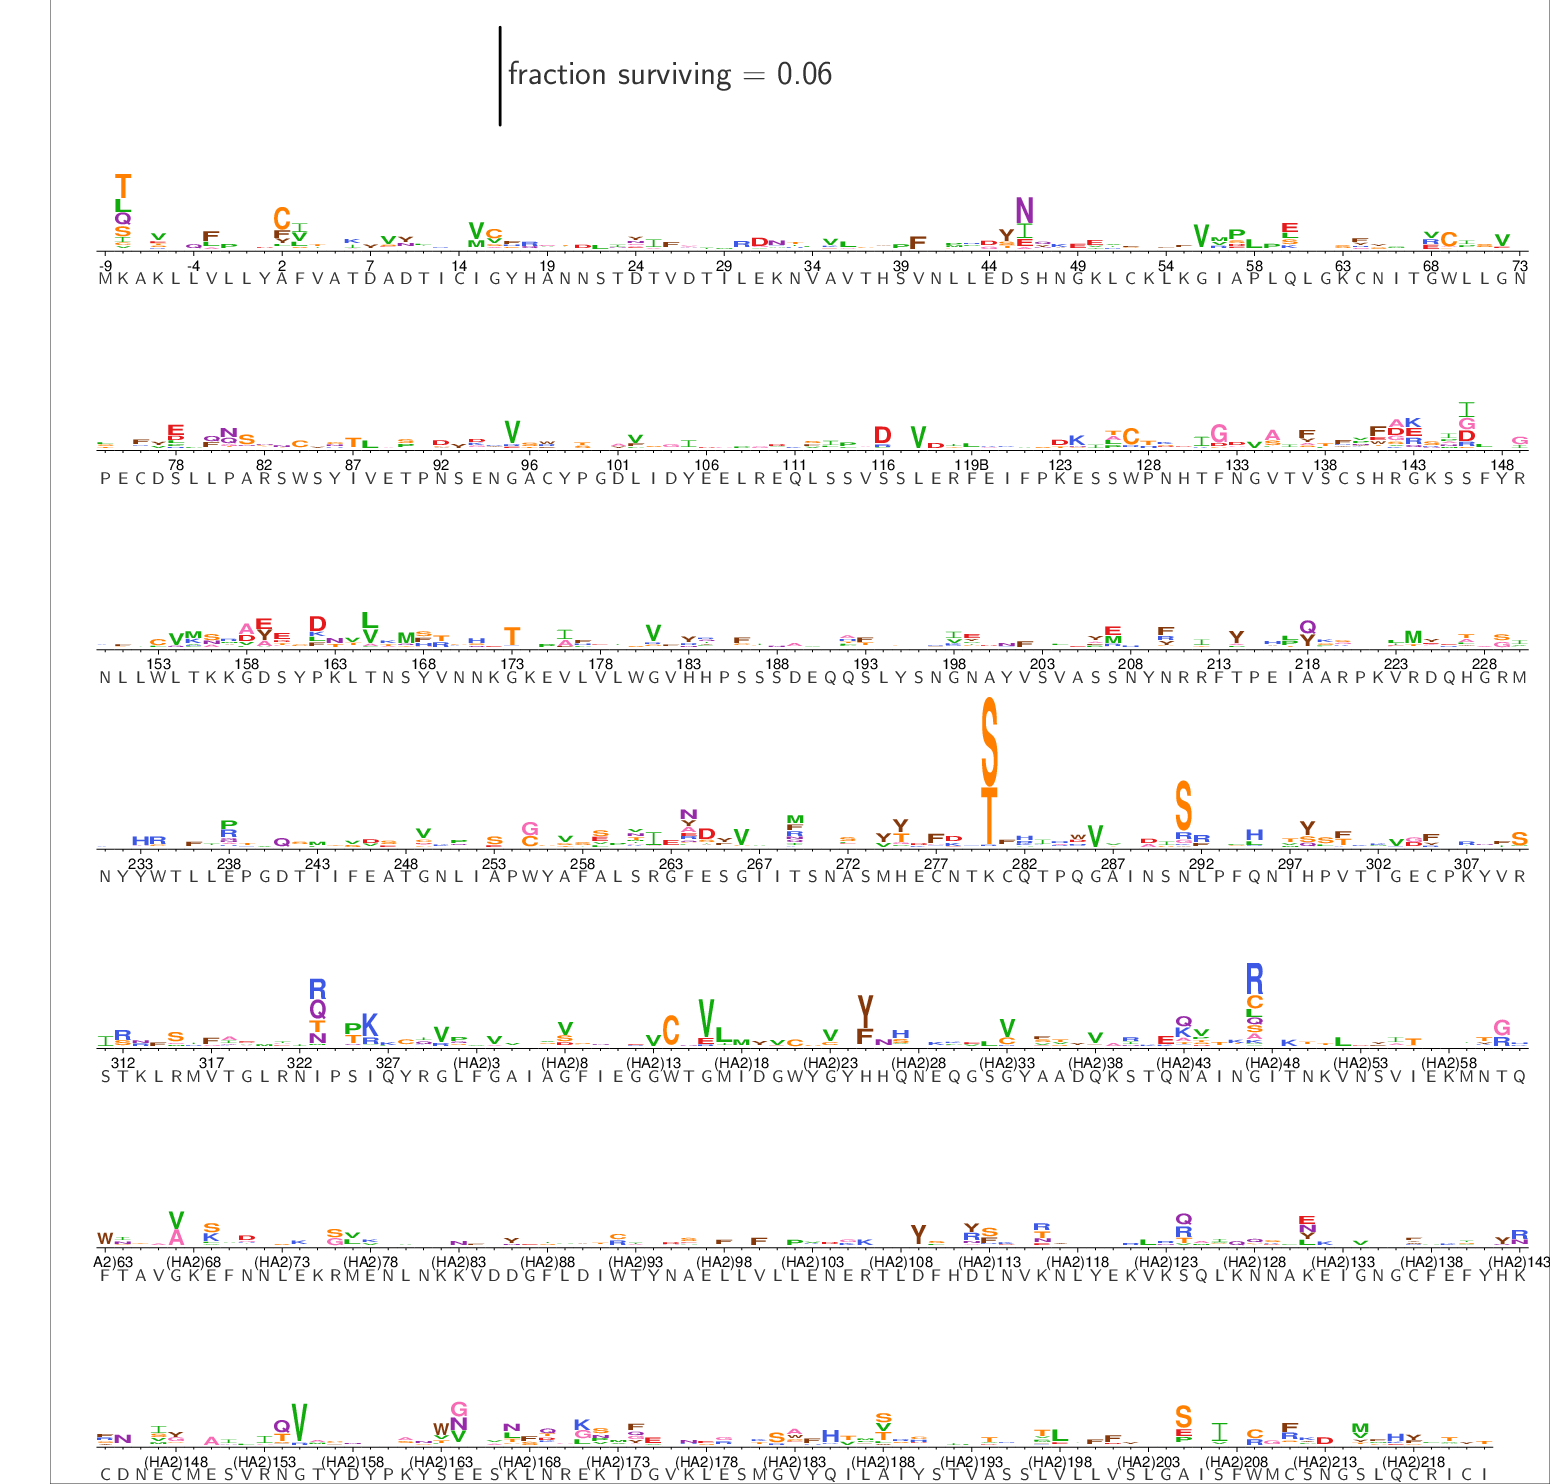


Getting and plotting overall across-concentration median for WSN vs CR9114
Writing across-concentration medians to ./results/fracsurviveaboveavg/antibody_CR9114_WSN_median.csv
Writing across-concentration site medians to ./results/fracsurviveaboveavg/antibody_CR9114_WSN_median_avgsite.csv
Creating logo plot ./results/fracsurviveaboveavg/WSN-CR9114_fracsurvive.pdf for CR9114 from ./results/fracsurviveaboveavg/antibody_CR9114_WSN_median.csv


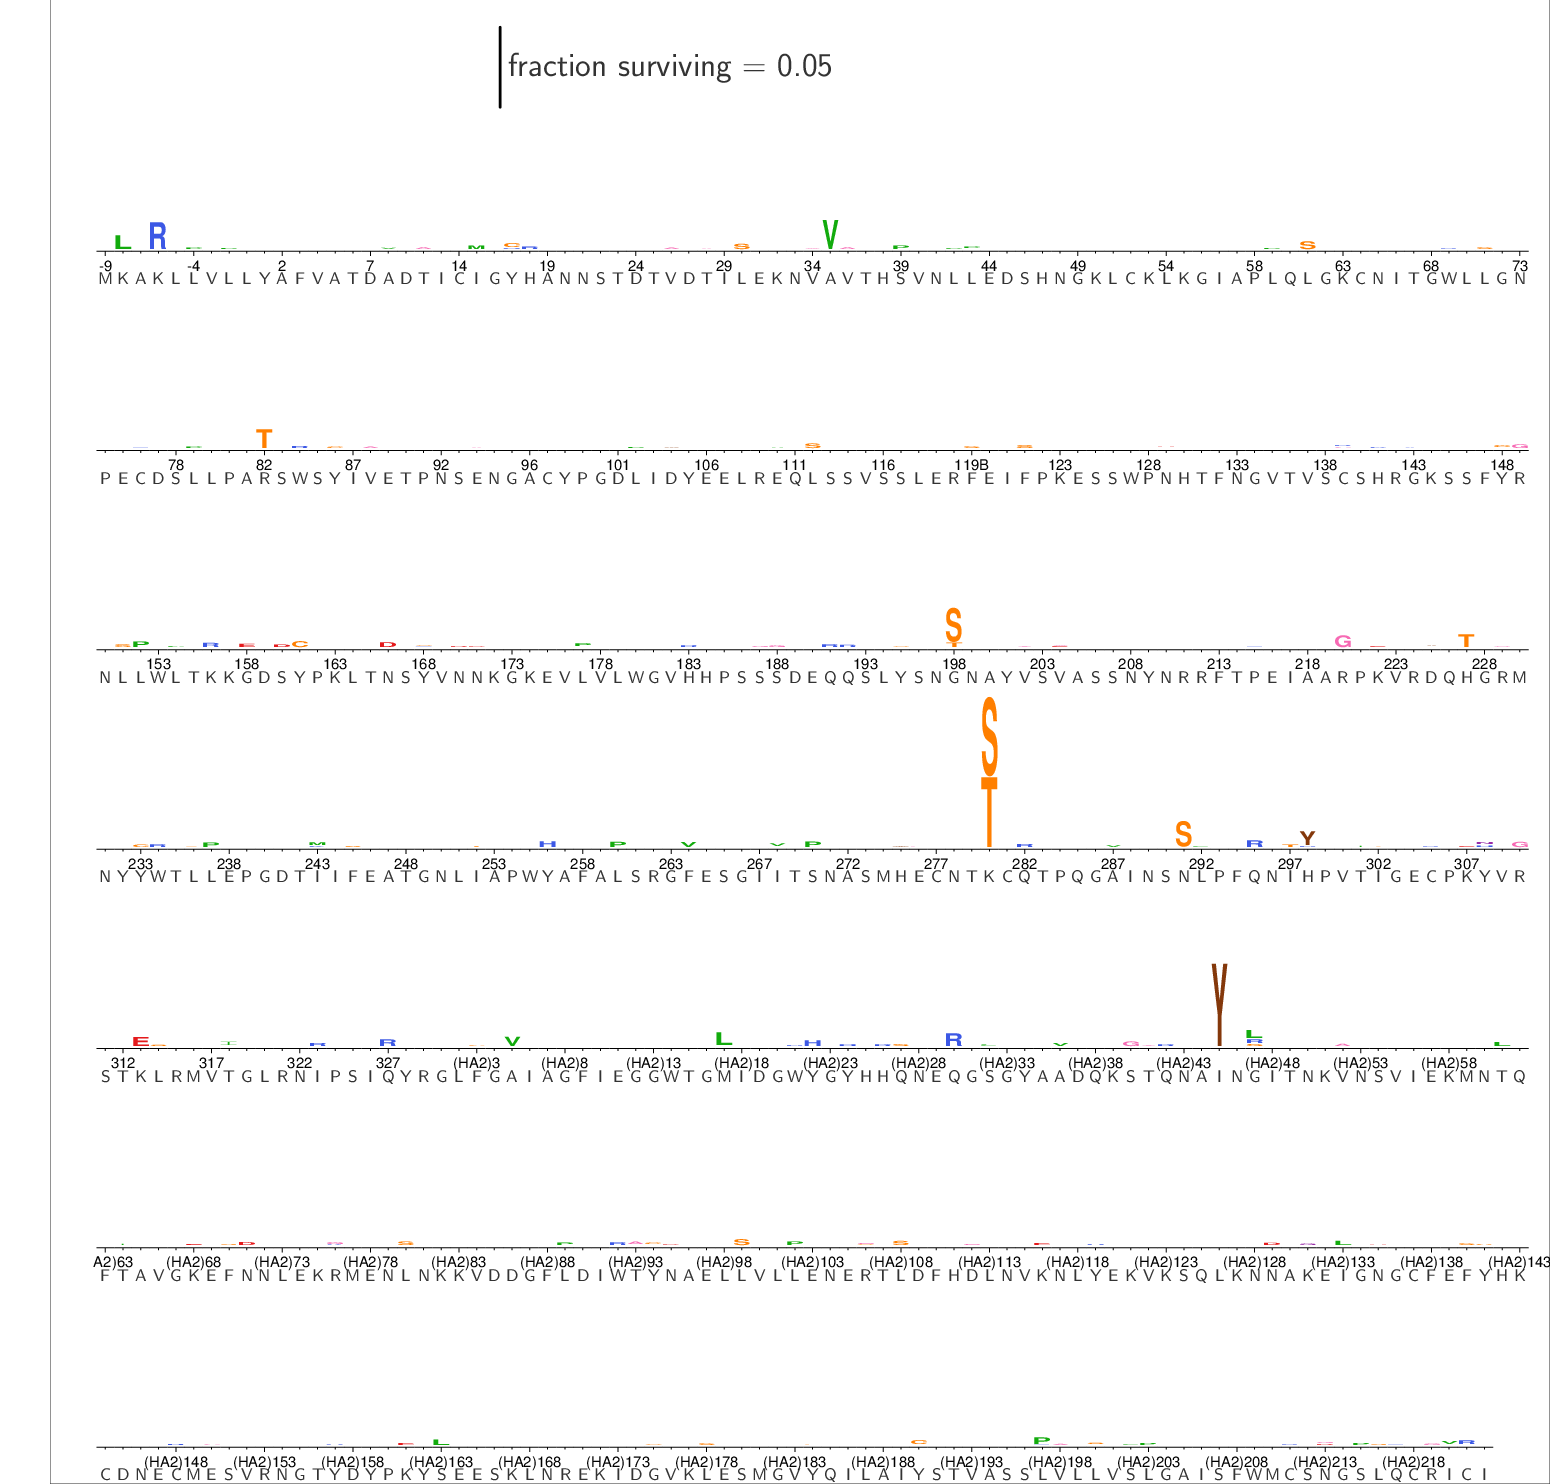


Getting and plotting overall across-concentration median for Perth vs FI6v3
Writing across-concentration medians to ./results/fracsurviveaboveavg/antibody_FI6v3_Perth_median.csv
Writing across-concentration site medians to ./results/fracsurviveaboveavg/antibody_FI6v3_Perth_median_avgsite.csv
Creating logo plot ./results/fracsurviveaboveavg/Perth-FI6v3_fracsurvive.pdf for FI6v3 from ./results/fracsurviveaboveavg/antibody_FI6v3_Perth_median.csv


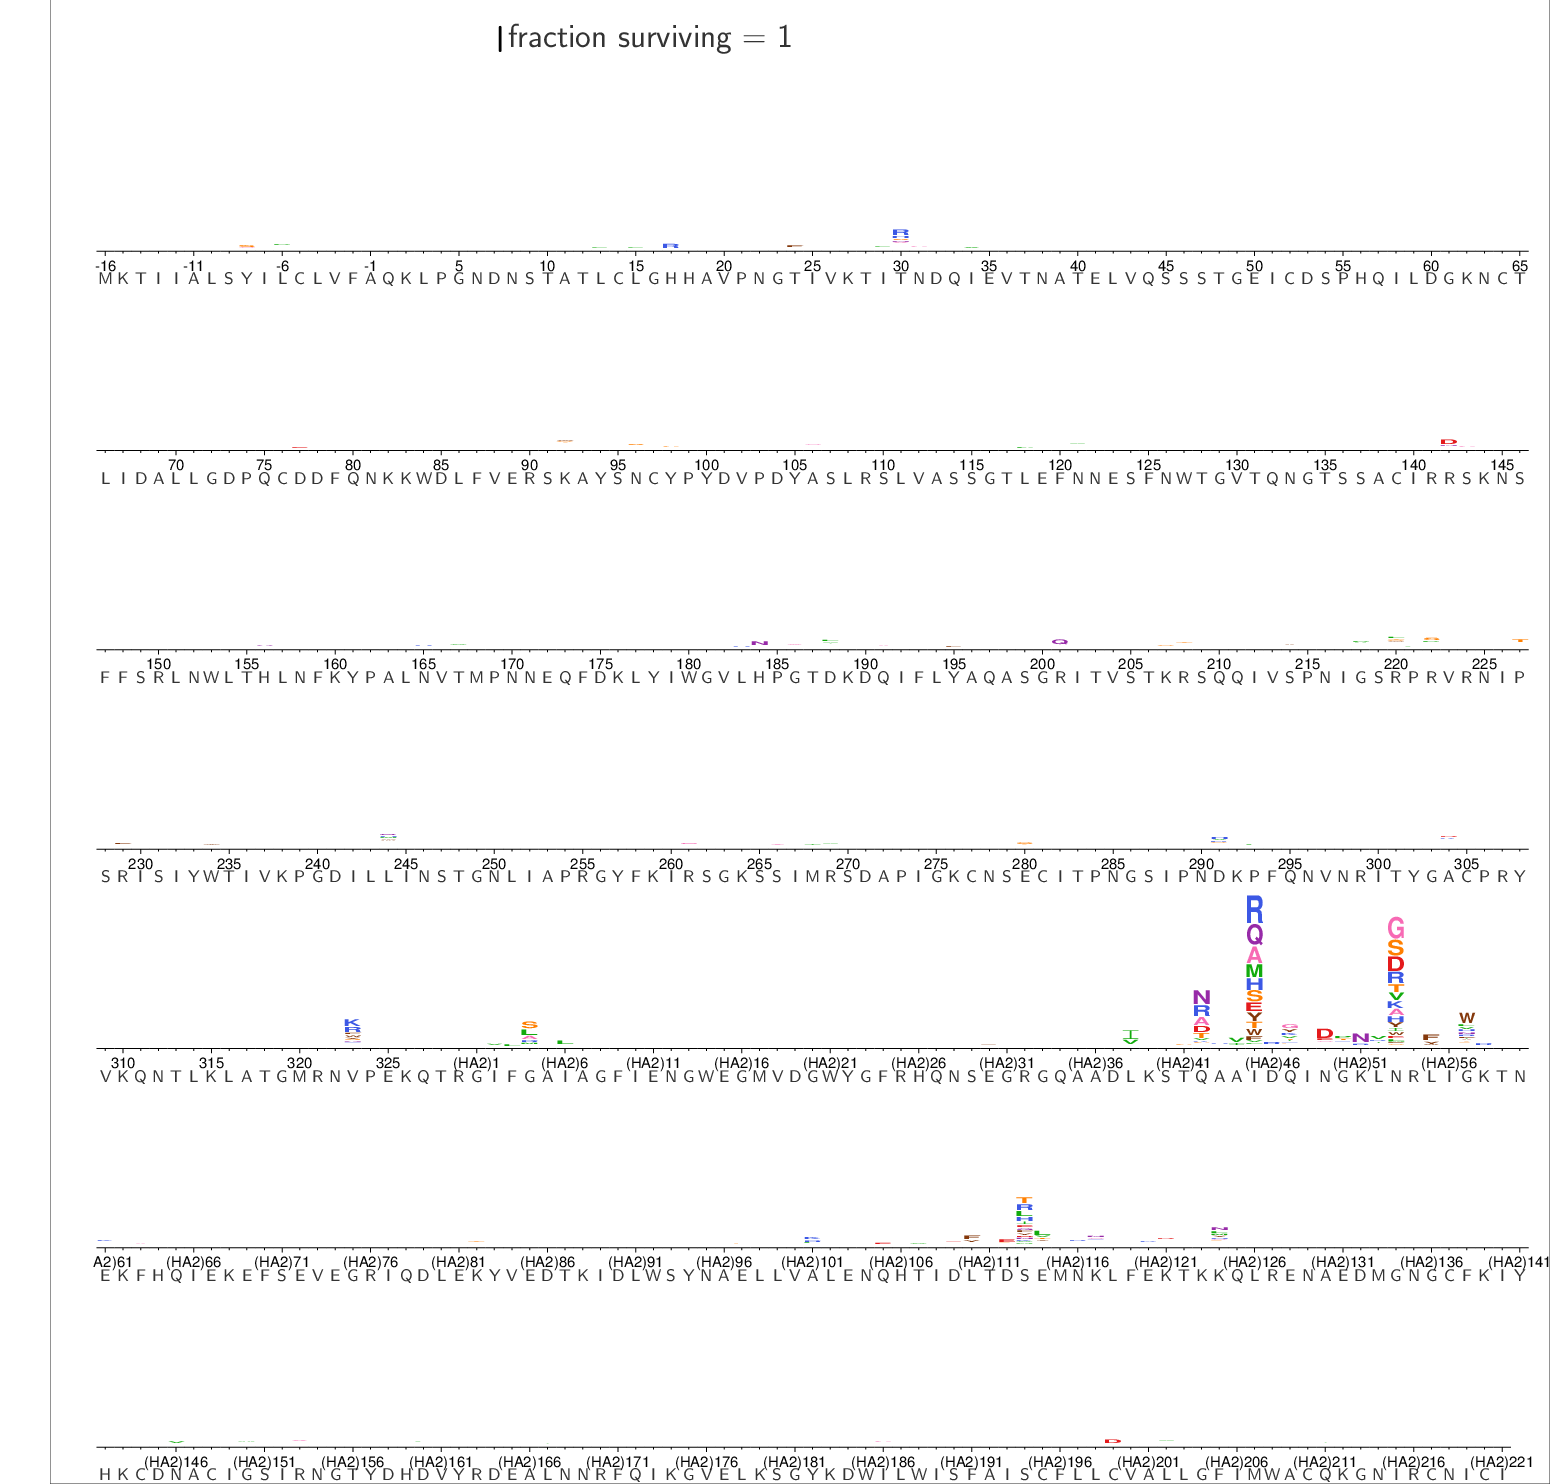

In [25]:
medianfiles = []
medavgsitefiles = []
logoplots = []
for (HA, batch) in [('WSN', WSNfracsurvivebatch), ('Perth', Perthfracsurvivebatch)]:
    for antibody in batch['antibody'].unique():
        print('\nGetting and plotting overall across-concentration median for {0} vs {1}'.format(HA, antibody))
        
        # list of files
        medianfracsurvive_files = glob.glob('{0}/{1}summary_{1}-{2}*medianmutfracsurvive.csv'
                .format(fracsurviveaboveavgdir, HA, antibody))
        
        # Average across mutation fraction surviving
        medianmutdf = dms_tools2.fracsurvive.avgMutFracSurvive(
                medianfracsurvive_files, 'median')
        
        # Convert median mutation to median avg site fraction surviving
        avgsitedf = dms_tools2.fracsurvive.mutToSiteFracSurvive(
                medianmutdf)
        
        # Write median mutation fracsurvive dataframe to csv files
        medianfile = os.path.join(fracsurviveaboveavgdir, 
                'antibody_{0}_{1}_median.csv'.format(antibody, HA))
        medianfiles.append(medianfile)
        print("Writing across-concentration medians to {0}".format(
                medianfile))
        medianmutdf.to_csv(medianfile, index=False)
        
        # Write median average site fracsurvive dataframe to csv files
        avgsitefile = os.path.join(fracsurviveaboveavgdir,
                'antibody_{0}_{1}_median_avgsite.csv'.format(antibody, HA))
        medavgsitefiles.append(avgsitefile)
        print("Writing across-concentration site medians to {0}".format(
                avgsitefile))
        avgsitedf.to_csv(avgsitefile, index=False)

        # now make logo plot
        # scale bar unit is maximum effect
        scaleunit = '{0:.1g}'.format(medianmutdf['mutfracsurvive'].max())
        scalelabel = '"fraction surviving = {0}"'.format(scaleunit)
        logoplot = os.path.join(fracsurviveaboveavgdir,
                '{0}-{1}_fracsurvive.pdf'.format(HA, antibody))
        logoplots.append(logoplot)
        print("Creating logo plot {0} for {1} from {2}".format(
                logoplot, antibody, medianfile))
        log = !dms2_logoplot \
                --fracsurvive {medianfile} \
                --name {HA}-{antibody} \
                --outdir {fracsurviveaboveavgdir} \
                --numberevery 5 \
                --nperline 81 \
                --underlay yes \
                --overlay1 {medianfile} wildtype wildtype \
                --scalebar {scaleunit} {scalelabel} \
                --use_existing {use_existing}

        showPDF(logoplot)

We can see from the logo plots above that both FI6v3 and CR9114 select for only a handful of mutations in the WSN H1 that have very small effects on escape. Interestingly, the mutations with the strongest effect sizes are the same for both antibodies (`K280S/T`), and introduce a glycosylation motif at site 278. CR9114 additionally selects for a mutation, I45(HA2)Y, that maps within the antibody-binding footprint.

In stark contrast to WSN H1 escape from these stalk-targeting antibodies, we see that many mutations in the Perth/2009 H3 are able to confer escape from FI6v3, and these mutations have quite large effect sizes. All of the sites of escape map within the footprint of where FI6v3 binds to the HA stalk domain.

## Plot logo plot snippets for sites of interest

We will now create zoomed logo plots for sites of interest.

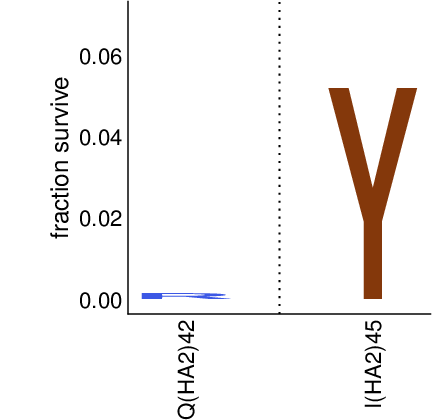

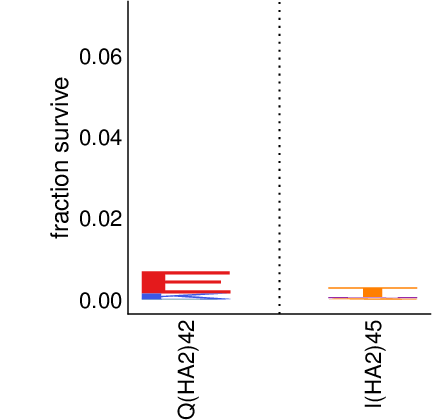

In [26]:
keysites = ['(HA2)42', '(HA2)45']
import natsort

names = ['WSN_CR9114', 'WSN_FI6v3']
fracsurvfiles = ['./results/fracsurviveaboveavg/antibody_CR9114_WSN_median.csv', 
                 './results/fracsurviveaboveavg/antibody_FI6v3_WSN_median.csv']

fracsurvs = [] #list of csv files
for fracsurv, name in zip(fracsurvfiles, names): 
    pandadf = pd.read_csv(fracsurv)
    # read data frame from tidy CSV format to wide form
    df = dms_tools2.diffsel.tidyToWide(pandadf, valuecol='mutfracsurvive')
    
    # only show positive values of mutdiffsel
    df[dms_tools2.AAS] = df[dms_tools2.AAS].clip(lower=0)
    
    #sort sites by 
    df = df.reindex(index=natsort.order_by_index(df.index,natsort.index_natsorted(df.site)))
    
    # add a column indicating what we should show
    df['show'] = df['site'].isin(keysites)
    
    # want to indicate wildtype along with site number, e.g, C52
    df['site'] = df['wildtype'] + df['site']
    # name of file to plot
    zoomlogoplot = os.path.join(plotsdir, '{0}_zoomed_fracsurvive.pdf'.format(name))
    # plot and show
    dms_tools2.rplot.siteSubsetGGSeqLogo(
            logodata=df,
            chars=dms_tools2.AAS,
            plotfile=zoomlogoplot,
            width=3,
            height=3.5,
            yname='fraction survive',
            ylimits=(0,0.07),
            )
    showPDF(zoomlogoplot)

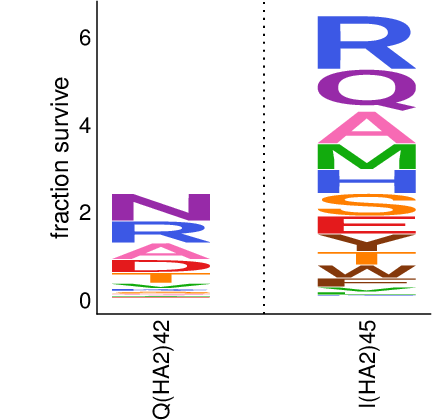

In [27]:
names = ['Perth2009_FI6v3']
fracsurvfiles = ['./results/fracsurviveaboveavg/antibody_FI6v3_Perth_median.csv']

fracsurvs = [] #list of csv files
for fracsurv, name in zip(fracsurvfiles, names): 
    pandadf = pd.read_csv(fracsurv)
    # read data frame from tidy CSV format to wide form
    df = dms_tools2.diffsel.tidyToWide(pandadf, valuecol='mutfracsurvive')
    
    # only show positive values of mutdiffsel
    df[dms_tools2.AAS] = df[dms_tools2.AAS].clip(lower=0)
    
    #sort sites by 
    df = df.reindex(index=natsort.order_by_index(df.index,natsort.index_natsorted(df.site)))
    
    # add a column indicating what we should show
    df['show'] = df['site'].isin(keysites)
    
    # want to indicate wildtype along with site number, e.g, C52
    df['site'] = df['wildtype'] + df['site']
    # name of file to plot
    zoomlogoplot = os.path.join(plotsdir, '{0}_zoomed_fracsurvive.pdf'.format(name))
    # plot and show
    dms_tools2.rplot.siteSubsetGGSeqLogo(
            logodata=df,
            chars=dms_tools2.AAS,
            plotfile=zoomlogoplot,
            width=3,
            height=3.5,
            yname='fraction survive',
            ylimits=(0,6.5),
            )
    showPDF(zoomlogoplot)

We will also plot the escape mutations in the zoomed logo plots all on the same y-axis scale, to compare the effect sizes of the mutations.

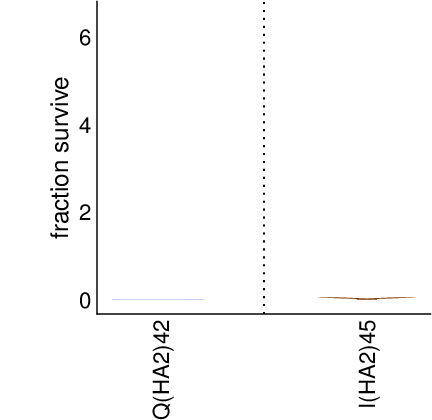

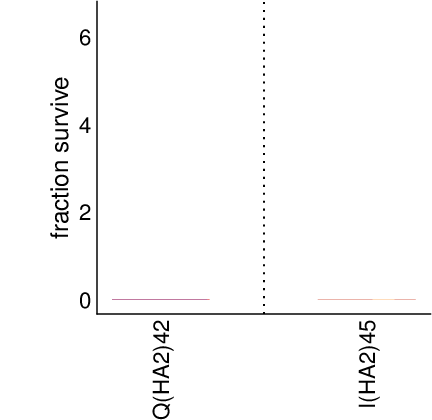

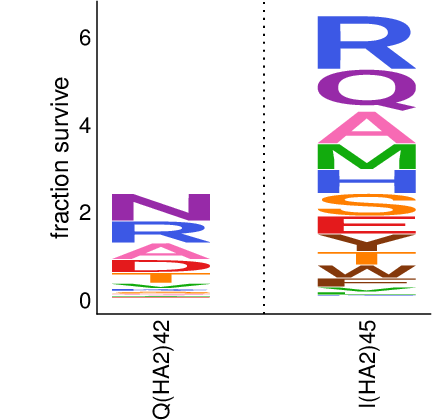

In [28]:
keysites = ['(HA2)42', '(HA2)45']
import natsort

names = ['WSN_CR9114', 'WSN_FI6v3', 'Perth2009_FI6v3']
fracsurvfiles = ['./results/fracsurviveaboveavg/antibody_CR9114_WSN_median.csv', 
                 './results/fracsurviveaboveavg/antibody_FI6v3_WSN_median.csv',
                 './results/fracsurviveaboveavg/antibody_FI6v3_Perth_median.csv']

fracsurvs = [] #list of csv files
for fracsurv, name in zip(fracsurvfiles, names): 
    pandadf = pd.read_csv(fracsurv)
    # read data frame from tidy CSV format to wide form
    df = dms_tools2.diffsel.tidyToWide(pandadf, valuecol='mutfracsurvive')
    
    # only show positive values of mutdiffsel
    df[dms_tools2.AAS] = df[dms_tools2.AAS].clip(lower=0)
    
    #sort sites by 
    df = df.reindex(index=natsort.order_by_index(df.index,natsort.index_natsorted(df.site)))
    
    # add a column indicating what we should show
    df['show'] = df['site'].isin(keysites)
    
    # want to indicate wildtype along with site number, e.g, C52
    df['site'] = df['wildtype'] + df['site']
    # name of file to plot
    zoomlogoplot = os.path.join(plotsdir, '{0}_zoomed_fracsurvive.pdf'.format(name))
    # plot and show
    dms_tools2.rplot.siteSubsetGGSeqLogo(
            logodata=df,
            chars=dms_tools2.AAS,
            plotfile=zoomlogoplot,
            width=3,
            height=3.5,
            yname='fraction survive',
            ylimits=(0,6.5),
            )
    showPDF(zoomlogoplot)